<a href="https://colab.research.google.com/github/NH0917/ghg/blob/main/lgb_cat_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openfe
#!pip install autogluon

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.9 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from openfe import OpenFE, transform
import io
import contextlib
#from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.preprocessing import LabelEncoder
import warnings
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool



warnings.simplefilter('ignore')

import sys

sys.path.append("/content/drive/MyDrive/signate/ghg/src/")
pd.set_option("display.max_columns",100)

#import my code
#import sub
#import plot_importance
#import train_evall_lgb

In [ ]:
class cfg:
    """Configuration class that holds hyperparameters for quicker experimenting"""
    num_folds = 10
    random_seed = 1
    n_jobs = 32
    n_features = 10

In [ ]:
train_path = "/content/drive/MyDrive/signate/ghg/data/train.csv"
test_path = "/content/drive/MyDrive/signate/ghg/data/test.csv"
sub_path = "/content/drive/MyDrive/signate/ghg/data/sample_submission.csv"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sub_df = pd.read_csv(sub_path,header=None)

In [ ]:
dropcol = ["FacilityName","LocationAddress","ZIP","SecondPrimaryNAICS"]
train.drop(columns=dropcol,inplace=True)
test.drop(columns=dropcol,inplace=True)

In [ ]:
def get_rmsle(y_true: np.array, y_pred: np.array) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric

    :param y_true: The ground truth labels given in the dataset
    :param y_pred: Our predictions
    :return: The RMSLE score
    """

    return mean_squared_log_error(y_true, y_pred, squared=False)

In [ ]:
def create_mesh(df):

  df["Longitude"]  = np.round(df["Longitude"],-1)
  df["Latitude"] = np.round(df["Latitude"],-1)
  df["group"] = df["Longitude"].astype(str) +"_"+ df["Latitude"].astype(str)

  replace_map = {
    "-130.0_60.0":"-150.0_60.0",
    "-160.0_70.0":"-150.0_70.0",
    "-170.0_50.0":"-150.0_60.0",
    "-60.0_20.0":"-70.0_20.0",
    "-70.0_50.0":"-70.0_40.0",
    "-80.0_20.0":"-80.0_30.0",
    "-80.0_50.0":"-80.0_40.0",
}
  df["group"] = df["group"].replace(replace_map)

  df = df.drop(columns=["Longitude","Latitude"])

  return df

In [ ]:
def preprocessing(train,test):
  train["dataset"] = "train"
  test["dataset"] = "test"
  df = pd.concat([train,test]).reset_index(drop=True)

  df["IndustryType"].fillna("Other",inplace=True)
  lecol = ["City","State","County","group"]

  df,create_col = cvt_dummy(df)
  df = df.drop(columns="Unnamed: 0")

  group_col = ["County","FIPScode","group","PrimaryNAICS","State"]
  create_col.extend(group_col)
  print(create_col)
  df = create_mesh(df)

  for col in lecol:
    le = LabelEncoder()
    df[col].fillna("NA",inplace=True)
    df[col] = le.fit_transform(df[col])

  #df = pca(df)

  #ghg_col = [x for x in train.columns if "GHG_" in x]
  #ghg_col.remove("GHG_Direct_Emissions_14_in_metric_tons")

  #for col in ghg_col:
  #  for t in group_col:
  #    ghg_map = df.groupby(t)[col].median().to_dict()
  #    df[f"{t}_{col}_median"] = df[t].map(ghg_map)


  train = df.query("dataset=='train'").reset_index(drop=True).drop(columns="dataset")
  test = df.query("dataset=='test'").reset_index(drop=True).drop(columns="dataset")



  return train,test,create_col

def cvt_dummy(df):

  temp_df = pd.concat([df["Unnamed: 0"],df["IndustryType"].str.split(",",expand=True)],axis="columns").reset_index(drop=True)
  temp_df = pd.melt(temp_df,id_vars="Unnamed: 0").dropna(axis=0).reset_index(drop=True)
  temp_df["variable"] = 1
  temp_df = pd.pivot_table(temp_df,index="Unnamed: 0",columns="value",values="variable").reset_index(drop=True).fillna(0)

  create_col = temp_df.columns.tolist()

  df = pd.concat([df,temp_df],axis="columns").reset_index(drop=True)

  return df,create_col

In [ ]:
train,test,create_col = preprocessing(train,test)

['Chemicals', 'Coal-based Liquid Fuel Supply', 'Import and Export of Equipment Containing Fluorintaed GHGs', 'Industrial Gas Suppliers', 'Injection of CO2', 'Metals', 'Minerals', 'Natural Gas and Natural Gas Liquids Suppliers', 'Other', 'Petroleum Product Suppliers', 'Petroleum and Natural Gas Systems', 'Power Plants', 'Pulp and Paper', 'Refineries', 'Suppliers of CO2', 'Waste', 'County', 'FIPScode', 'group', 'PrimaryNAICS', 'State']


In [ ]:
ghg_col = [x for x in train.columns if "GHG_" in x]
ghg_col.remove("GHG_Direct_Emissions_14_in_metric_tons")

In [ ]:
ghg_cat_col = []

for col in ghg_col:
  temp = train[col].fillna(0)
  train[f"{col}_bins"] = pd.qcut(temp,q=60,duplicates="drop",labels=False)
  test[f"{col}_bins"] = pd.qcut(temp,q=60,duplicates="drop",labels=False)
  ghg_cat_col.append(f"{col}_bins")
#70
#60

train["group_kfold"] = pd.qcut(train["group"],q=10,duplicates="drop",labels=False)
test["group_kfold"] = pd.qcut(test["group"],q=10,duplicates="drop",labels=False)

In [ ]:

train.head()
train = train.drop(columns="IndustryType")

In [ ]:
rename_map = {}

for col in train.columns:
  rename_map[col] = col.replace(" ","_").replace("-","_")

train.rename(columns=rename_map,inplace=True)
test.rename(columns=rename_map,inplace=True)

In [ ]:
ghg_col = [x for x in train.columns if "GHG_" in x]
ghg_col.remove("GHG_Direct_Emissions_14_in_metric_tons")
train["GHG_mean"] = train[ghg_col].mean(axis=1)
test["GHG_mean"] = test[ghg_col].mean(axis=1)

#train.drop(columns="GHG_mean",inplace=True)
#test.drop(columns="GHG_mean",inplace=True)
ghg_col.append("GHG_mean")

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

target_col = "GHG_Direct_Emissions_14_in_metric_tons"

test_rmsle_values = []

output_path = "/content/drive/MyDrive/signate/ghg/exp/model11"

cat_col = [ 'PrimaryNAICS','Chemicals',
       'Coal_based_Liquid_Fuel_Supply',
       'Import_and_Export_of_Equipment_Containing_Fluorintaed_GHGs',
       'Industrial_Gas_Suppliers', 'Injection_of_CO2', 'Metals', 'Minerals',
       'Natural_Gas_and_Natural_Gas_Liquids_Suppliers', 'Other',
       'Petroleum_Product_Suppliers', 'Petroleum_and_Natural_Gas_Systems',
       'Power_Plants', 'Pulp_and_Paper', 'Refineries', 'Suppliers_of_CO2',
       'Waste', 'group']

cat_col.extend(ghg_cat_col)

unusecol = ["City","State","County", 'FIPScode']


param = {
    "objective":"regression",
    "metric":"rmse",
    "verbosity":-1,
    "learning_rate":0.01,
    "seed":42,
}

models = []


X = train.drop(columns=target_col).reset_index(drop=True)
y = train[target_col].reset_index(drop=True)

X = X.drop(columns=unusecol).reset_index(drop=True)


buffer = io.StringIO()
#kf = StratifiedKFold(n_splits=cfg.num_folds,shuffle=True,random_state=42)
kf = KFold(n_splits=cfg.num_folds,shuffle=True,random_state=42)

X.drop(columns="group_kfold",inplace=True)

oof_dfs = pd.DataFrame()

buffer = io.StringIO()
with contextlib.redirect_stdout(buffer):

  ofe = OpenFE()
  features = ofe.fit(data=X,label=y,n_jobs=cfg.n_jobs,verbose=-1,task='regression',categorical_features=cat_col,feature_boosting=False)

X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

for i,(train_index,test_index) in enumerate(kf.split(X)):
  x_train_fold = X.iloc[train_index].reset_index(drop=True)
  y_train_fold = np.log1p(y.iloc[train_index].reset_index(drop=True))
  x_test_fold = X.iloc[test_index].reset_index(drop=True)
  y_test_fold = np.log1p(y.iloc[test_index].reset_index(drop=True))
  x_train,x_valid = transform(x_train_fold,x_test_fold,features[:10],n_jobs=cfg.n_jobs)

  x_train = x_train.drop(columns=cat_col)
  x_valid = x_valid.drop(columns=cat_col)
  x_train["GHG_mean"] = x_train[ghg_col].mean(axis=1)
  x_valid["GHG_mean"] = x_valid[ghg_col].mean(axis=1)
  #x_train = x_train[usecol]
  #x_valid = x_valid[usecol]
  #x_train_fold = x_train_fold.drop(columns="group_kfold")
  #x_test_fold = x_test_fold.drop(columns="group_kfold")

  lgb_train = lgb.Dataset(x_train.values,y_train_fold.values)
  lgb_eval = lgb.Dataset(x_valid.values,y_test_fold.values,reference=lgb_train)

  model = lgb.train(param,lgb_train,valid_sets=[lgb_train,lgb_eval],num_boost_round=10_000,callbacks=[lgb.early_stopping(stopping_rounds=20,verbose=True)])
  y_pred = model.predict(x_valid.values)
  rmsle_test_fold = mean_squared_error(y_test_fold,y_pred,squared=False)
  print(f"Fold {i} RMSLE: {rmsle_test_fold}")

  test_rmsle_values.append(rmsle_test_fold)

  model.save_model(f"{output_path}/lgb_regressor_fold_{i}.json")
  models.append(model)

  oof_df = pd.DataFrame()
  oof_df["target"] = np.exp(y_test_fold)-1
  oof_df["pred"] = np.exp(y_pred)-1

  oof_dfs = pd.concat([oof_df,oof_dfs]).reset_index(drop=True)
  models.append(model)

average_test_rmsle = sum(test_rmsle_values)/cfg.num_folds
print(f'Average Validation RMSLE across all {cfg.num_folds} folds is {average_test_rmsle}')

100%|██████████| 115/115 [00:10<00:00, 10.48it/s]


KeyError: "['GHG_Direct_Emissions_10_in_metric_tons_bins', 'GHG_Direct_Emissions_11_in_metric_tons_bins', 'GHG_Direct_Emissions_12_in_metric_tons_bins', 'GHG_Direct_Emissions_13_in_metric_tons_bins'] not in index"

In [ ]:
#0.7598083302372867

In [ ]:
usecol = x_train.columns.tolist()
_,test_df = transform(train,test,features[:20],n_jobs=cfg.n_jobs)

In [ ]:
output_path = "/content/drive/MyDrive/signate/ghg/exp/model11"

oof_dfs.to_csv(f"{output_path}/oof_dfs_lgb.csv",index=False)



pred_df = pd.DataFrame()
fold=0
for ml in models:
  pred_df[f"{fold}"] = np.exp(ml.predict(test_df[usecol].values))-1
  fold+=1

pred_df["target"] = pred_df.mean(axis=1)
pred_df["target"].to_csv(f"{output_path}/pred_df_lgb.csv",index=False)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

target_col = "GHG_Direct_Emissions_14_in_metric_tons"

test_rmsle_values = []

output_path = "/content/drive/MyDrive/signate/ghg/exp/model11"

cat_col = [ 'PrimaryNAICS','Chemicals',
       'Coal_based_Liquid_Fuel_Supply',
       'Import_and_Export_of_Equipment_Containing_Fluorintaed_GHGs',
       'Industrial_Gas_Suppliers', 'Injection_of_CO2', 'Metals', 'Minerals',
       'Natural_Gas_and_Natural_Gas_Liquids_Suppliers', 'Other',
       'Petroleum_Product_Suppliers', 'Petroleum_and_Natural_Gas_Systems',
       'Power_Plants', 'Pulp_and_Paper', 'Refineries', 'Suppliers_of_CO2',
       'Waste', 'group']

cat_col.extend(ghg_cat_col)

unusecol = ["City","State","County", 'FIPScode']


param = {
    "objective":"regression",
    "metric":"rmse",
    "verbosity":-1,
    "learning_rate":0.01,
    "seed":42,
}

models = []


X = train.drop(columns=target_col).reset_index(drop=True)
y = train[target_col].reset_index(drop=True)

X = X.drop(columns=unusecol).reset_index(drop=True)


buffer = io.StringIO()
kf = KFold(n_splits=cfg.num_folds,shuffle=True,random_state=42)


oof_dfs = pd.DataFrame()

buffer = io.StringIO()
with contextlib.redirect_stdout(buffer):

  ofe = OpenFE()
  features = ofe.fit(data=X,label=y,n_jobs=cfg.n_jobs,verbose=-1,task='regression',categorical_features=cat_col)

X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

for i,(train_index,test_index) in enumerate(kf.split(X)):
  x_train_fold = X.iloc[train_index].reset_index(drop=True)
  y_train_fold = np.log1p(y.iloc[train_index].reset_index(drop=True))
  x_test_fold = X.iloc[test_index].reset_index(drop=True)
  y_test_fold = np.log1p(y.iloc[test_index].reset_index(drop=True))

  x_train,x_valid = transform(x_train_fold,x_test_fold,features[:20],n_jobs=cfg.n_jobs)

  x_train = x_train.drop(columns=cat_col)
  x_valid = x_valid.drop(columns=cat_col)

  c_train = Pool(x_train.values,y_train_fold.values)
  c_val = Pool(x_valid.values,y_test_fold.values,)

  model = CatBoostRegressor(loss_function="RMSE")
  model.fit(c_train,eval_set=c_val,use_best_model=True,early_stopping_rounds=20)

  oof_df = pd.DataFrame()
  oof_df["pred"] = model.predict(x_valid)
  oof_df["pred"] = np.exp(oof_df["pred"])-1

  oof_df["target"] = np.exp(y_test_fold)-1

  oof_dfs = pd.concat([oof_df,oof_dfs]).reset_index(drop=True)
  models.append(model)


100%|██████████| 117/117 [00:10<00:00, 11.43it/s]


Learning rate set to 0.063763
0:	learn: 1.2678445	test: 1.2393315	best: 1.2393315 (0)	total: 3.57ms	remaining: 3.56s
1:	learn: 1.2228589	test: 1.1911024	best: 1.1911024 (1)	total: 6.59ms	remaining: 3.29s
2:	learn: 1.1814956	test: 1.1458603	best: 1.1458603 (2)	total: 9.5ms	remaining: 3.16s
3:	learn: 1.1450985	test: 1.1075585	best: 1.1075585 (3)	total: 12.5ms	remaining: 3.1s
4:	learn: 1.1106923	test: 1.0713050	best: 1.0713050 (4)	total: 15.4ms	remaining: 3.06s
5:	learn: 1.0797922	test: 1.0384462	best: 1.0384462 (5)	total: 18.4ms	remaining: 3.05s
6:	learn: 1.0513941	test: 1.0080164	best: 1.0080164 (6)	total: 21.8ms	remaining: 3.09s
7:	learn: 1.0236072	test: 0.9786034	best: 0.9786034 (7)	total: 24.6ms	remaining: 3.06s
8:	learn: 1.0006720	test: 0.9537649	best: 0.9537649 (8)	total: 27.7ms	remaining: 3.04s
9:	learn: 0.9789615	test: 0.9314691	best: 0.9314691 (9)	total: 30.5ms	remaining: 3.02s
10:	learn: 0.9578045	test: 0.9096534	best: 0.9096534 (10)	total: 33.4ms	remaining: 3s
11:	learn: 0.939

In [ ]:
get_rmsle(oof_dfs["target"],oof_dfs["pred"])

0.7591251446187152

In [ ]:
test[usecol]

KeyError: "['autoFE_f_0', 'autoFE_f_1', 'autoFE_f_2', 'autoFE_f_3', 'autoFE_f_4', 'autoFE_f_5', 'autoFE_f_6', 'autoFE_f_7', 'autoFE_f_8', 'autoFE_f_9', 'autoFE_f_10', 'autoFE_f_11', 'autoFE_f_12', 'autoFE_f_13', 'autoFE_f_14', 'autoFE_f_15', 'autoFE_f_16', 'autoFE_f_17', 'autoFE_f_18', 'autoFE_f_19'] not in index"

In [ ]:
output_path = "/content/drive/MyDrive/signate/ghg/exp/model11"

pred_df = pd.DataFrame()
fold=0
for ml in models:
  pred_df[f"{fold}"] = np.exp(ml.predict(test_df[usecol].values))-1
  fold+=1
pred_df["target"] = pred_df.mean(axis=1)
pred_df["target"].to_csv(f"{output_path}/pred_df_cat.csv",index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lgb(models,usecol):

    feature_importance_list = []

    for ml in models:
        feature = ml.feature_importance()
        feature_importance_list.append(feature)
        feature_df = pd.DataFrame(np.array(feature_importance_list).T,index=usecol)
        feature_df.reset_index(drop=False,inplace=True)
        feature_df["shap_sum"] = feature_df.iloc[:,1:-1].mean(axis=1)

    fig,ax = plt.subplots(figsize=(20,20))

    sns.barplot(x="shap_sum",y="index",data=feature_df.sort_values(by="shap_sum",ascending=False))

    return feature_df

def plot_lgb_per_fold(models,usecol):
    for ml in models:
        feature = ml.feature_importance()
        feature_df = pd.DataFrame(feature.T,index=usecol).sort_values(by=0,ascending=False)
        feature_df.reset_index(drop=False,inplace=True)

        fig,ax = plt.subplots(figsize=(20,20))

        sns.barplot(data=feature_df,y="index",x=0)
        plt.show()

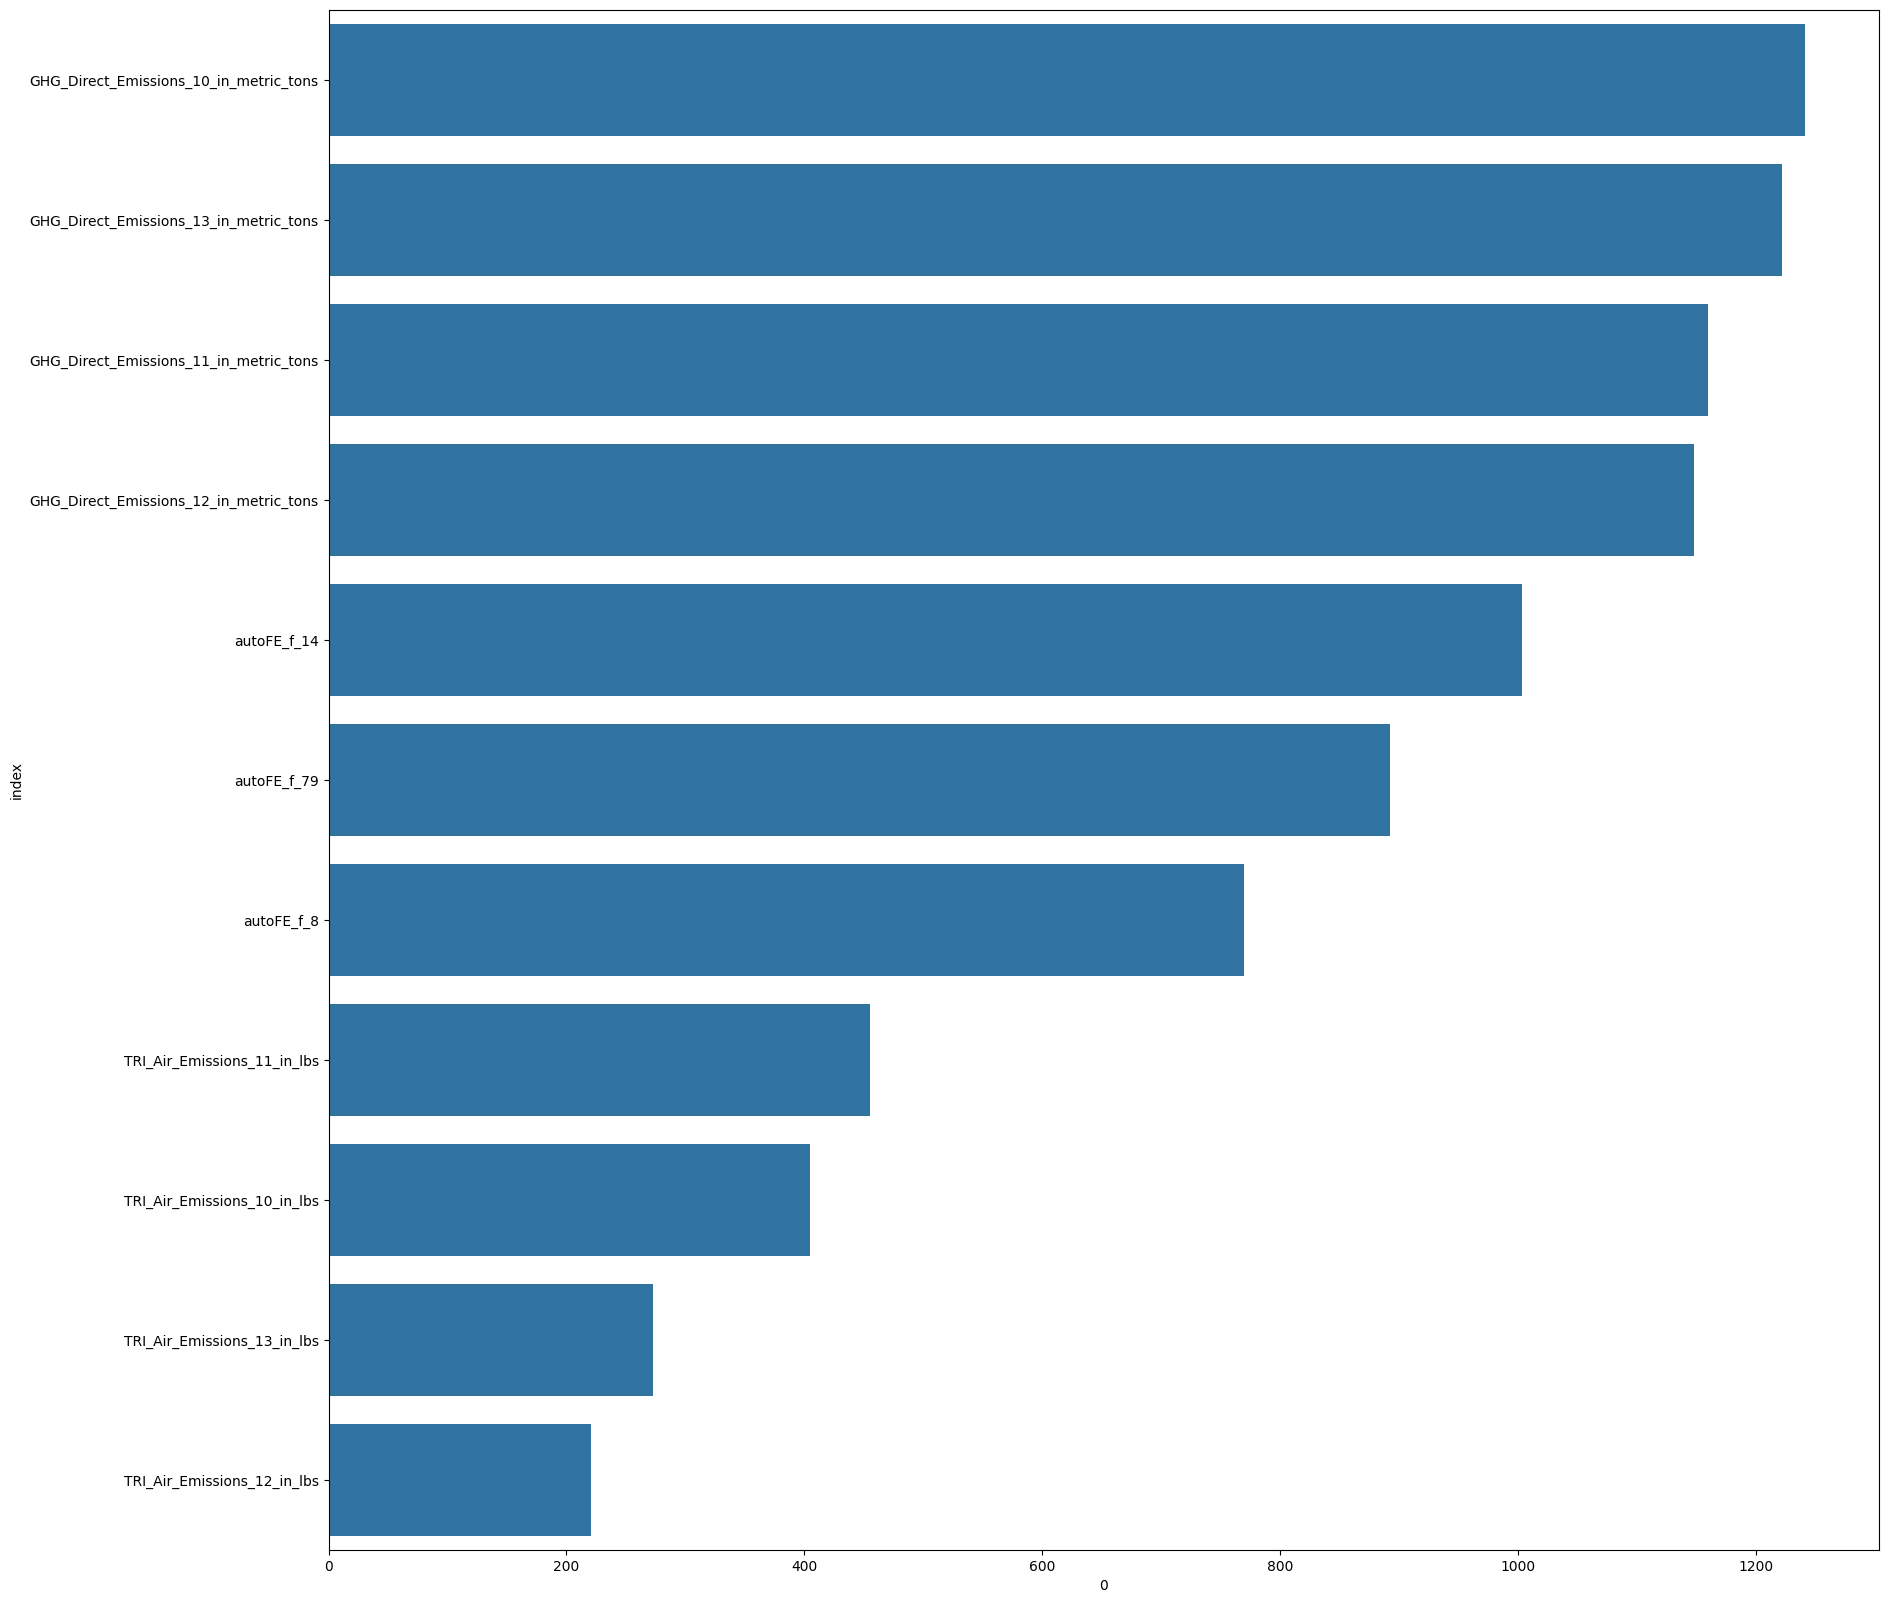

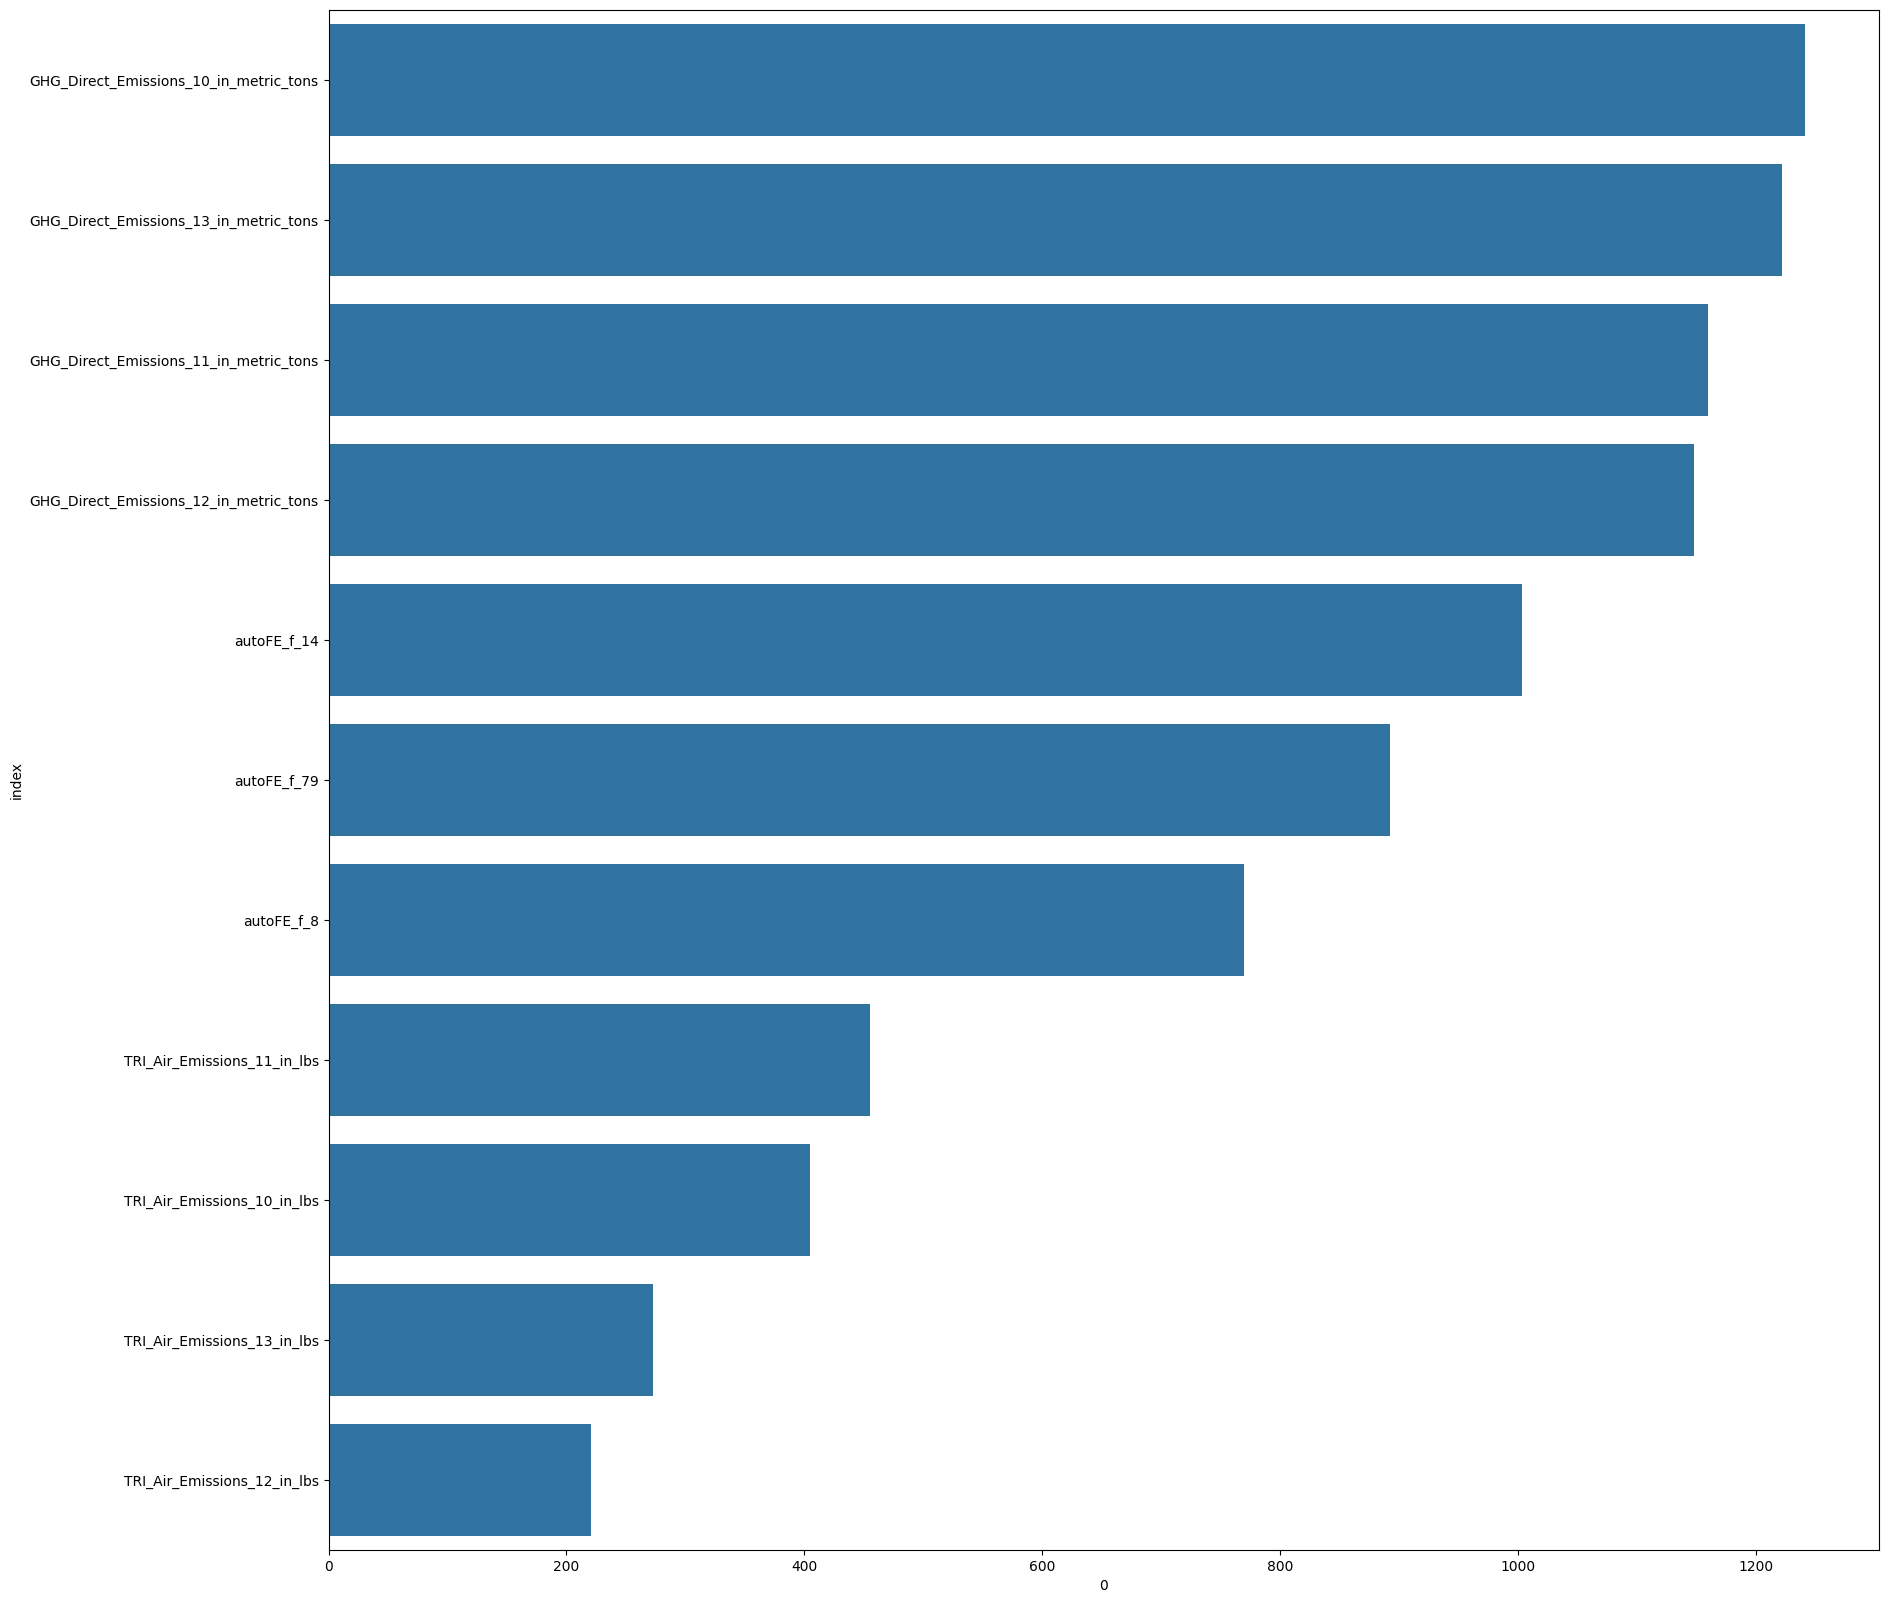

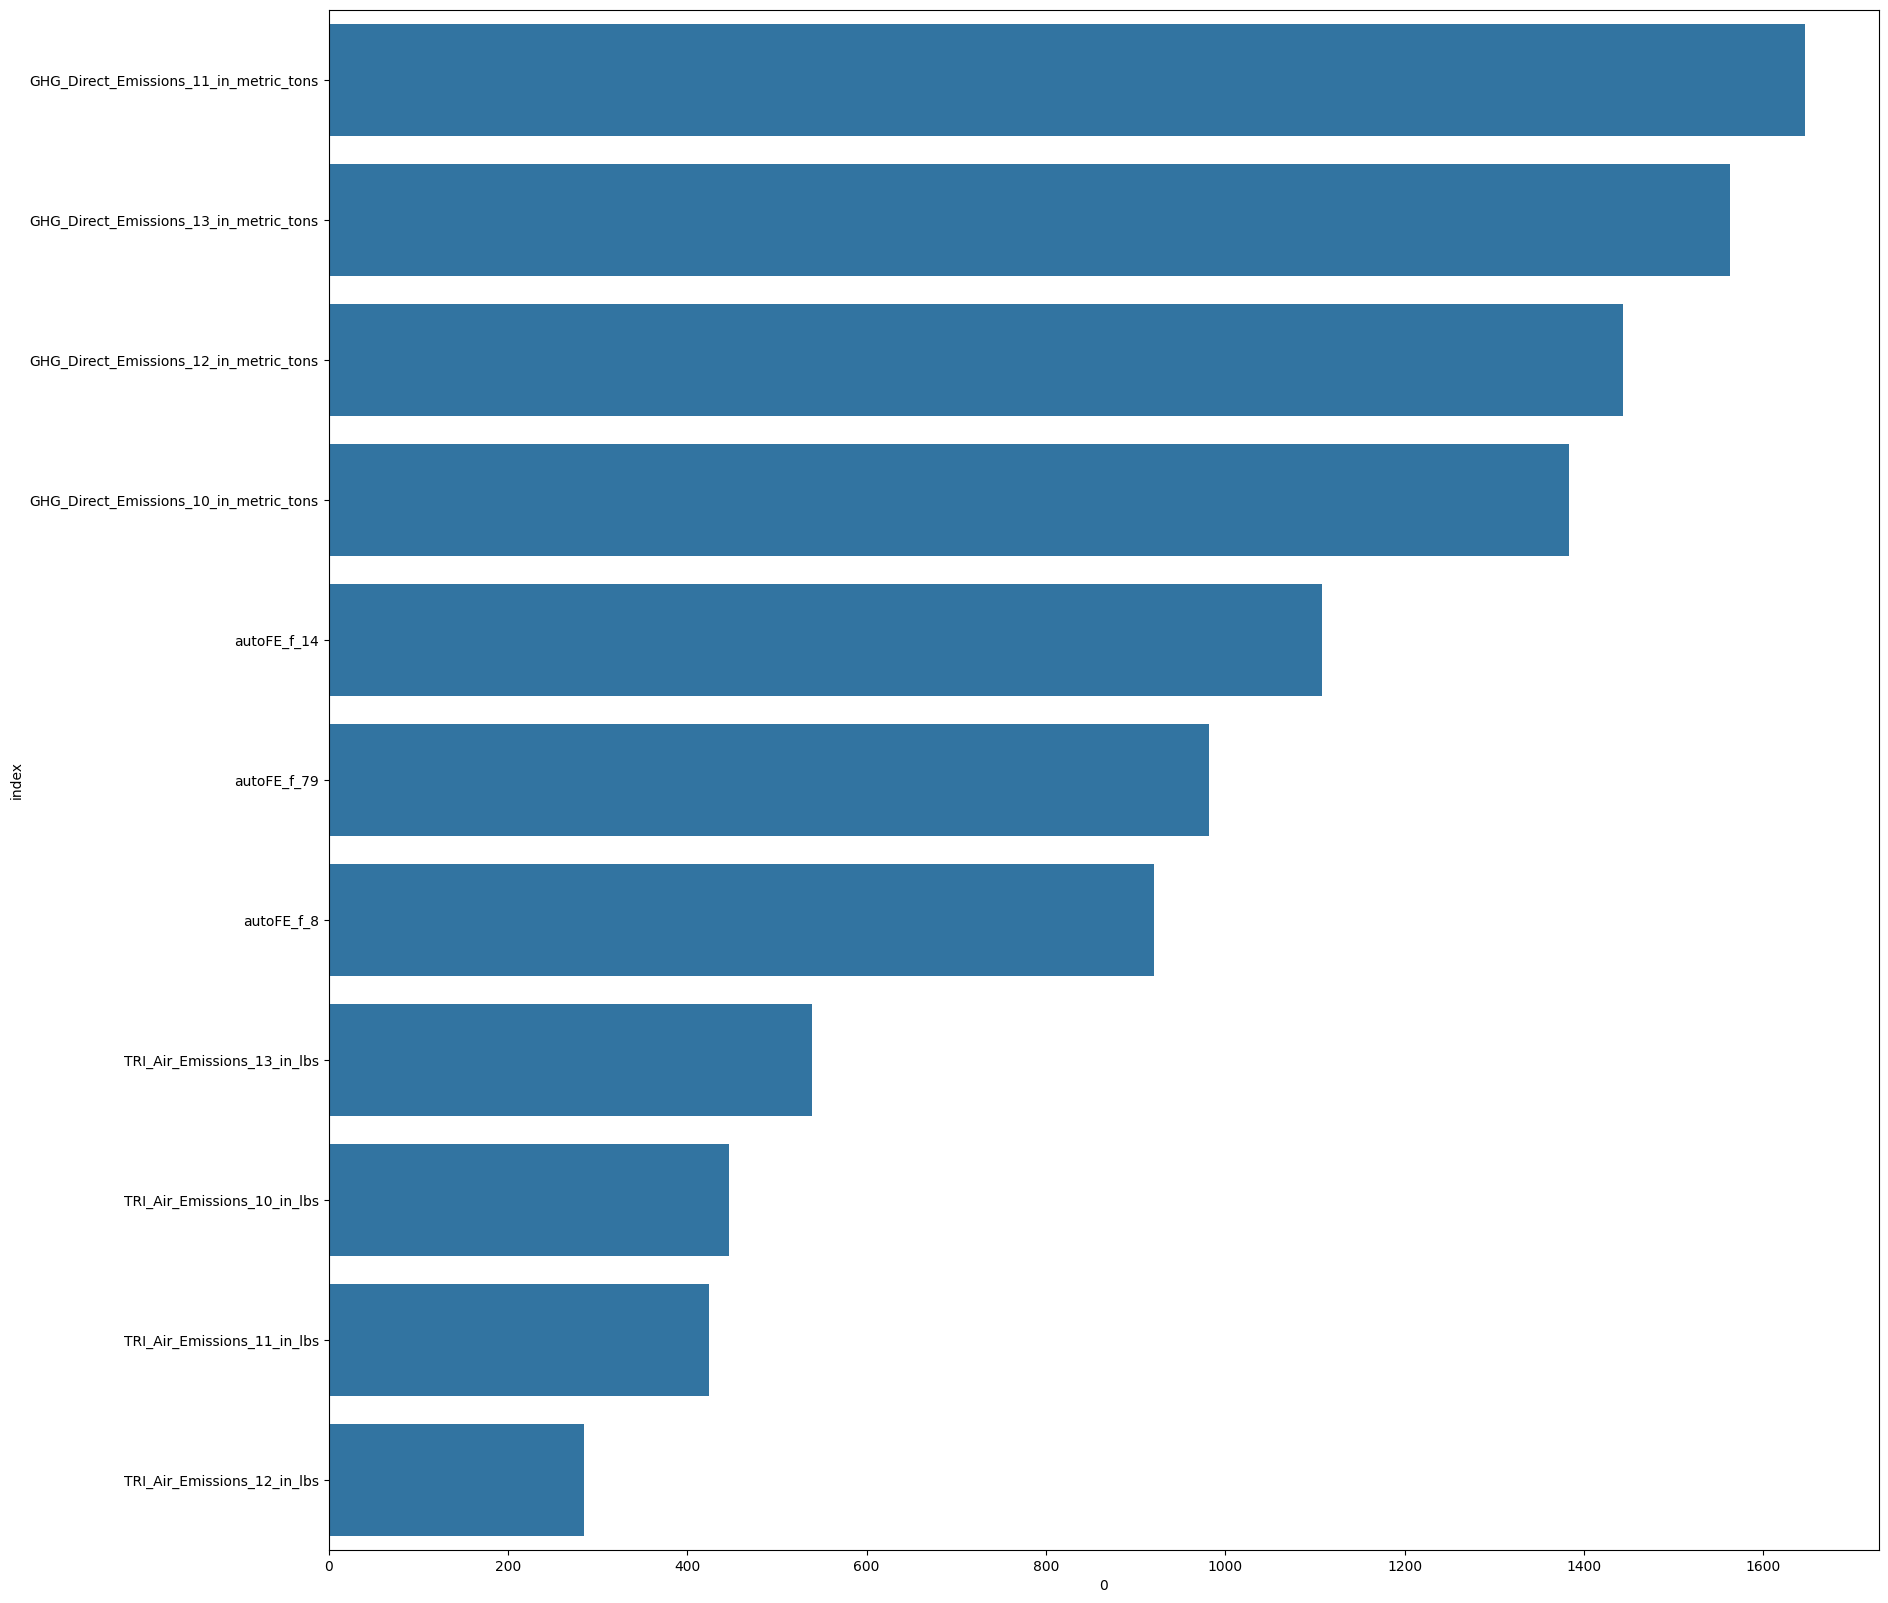

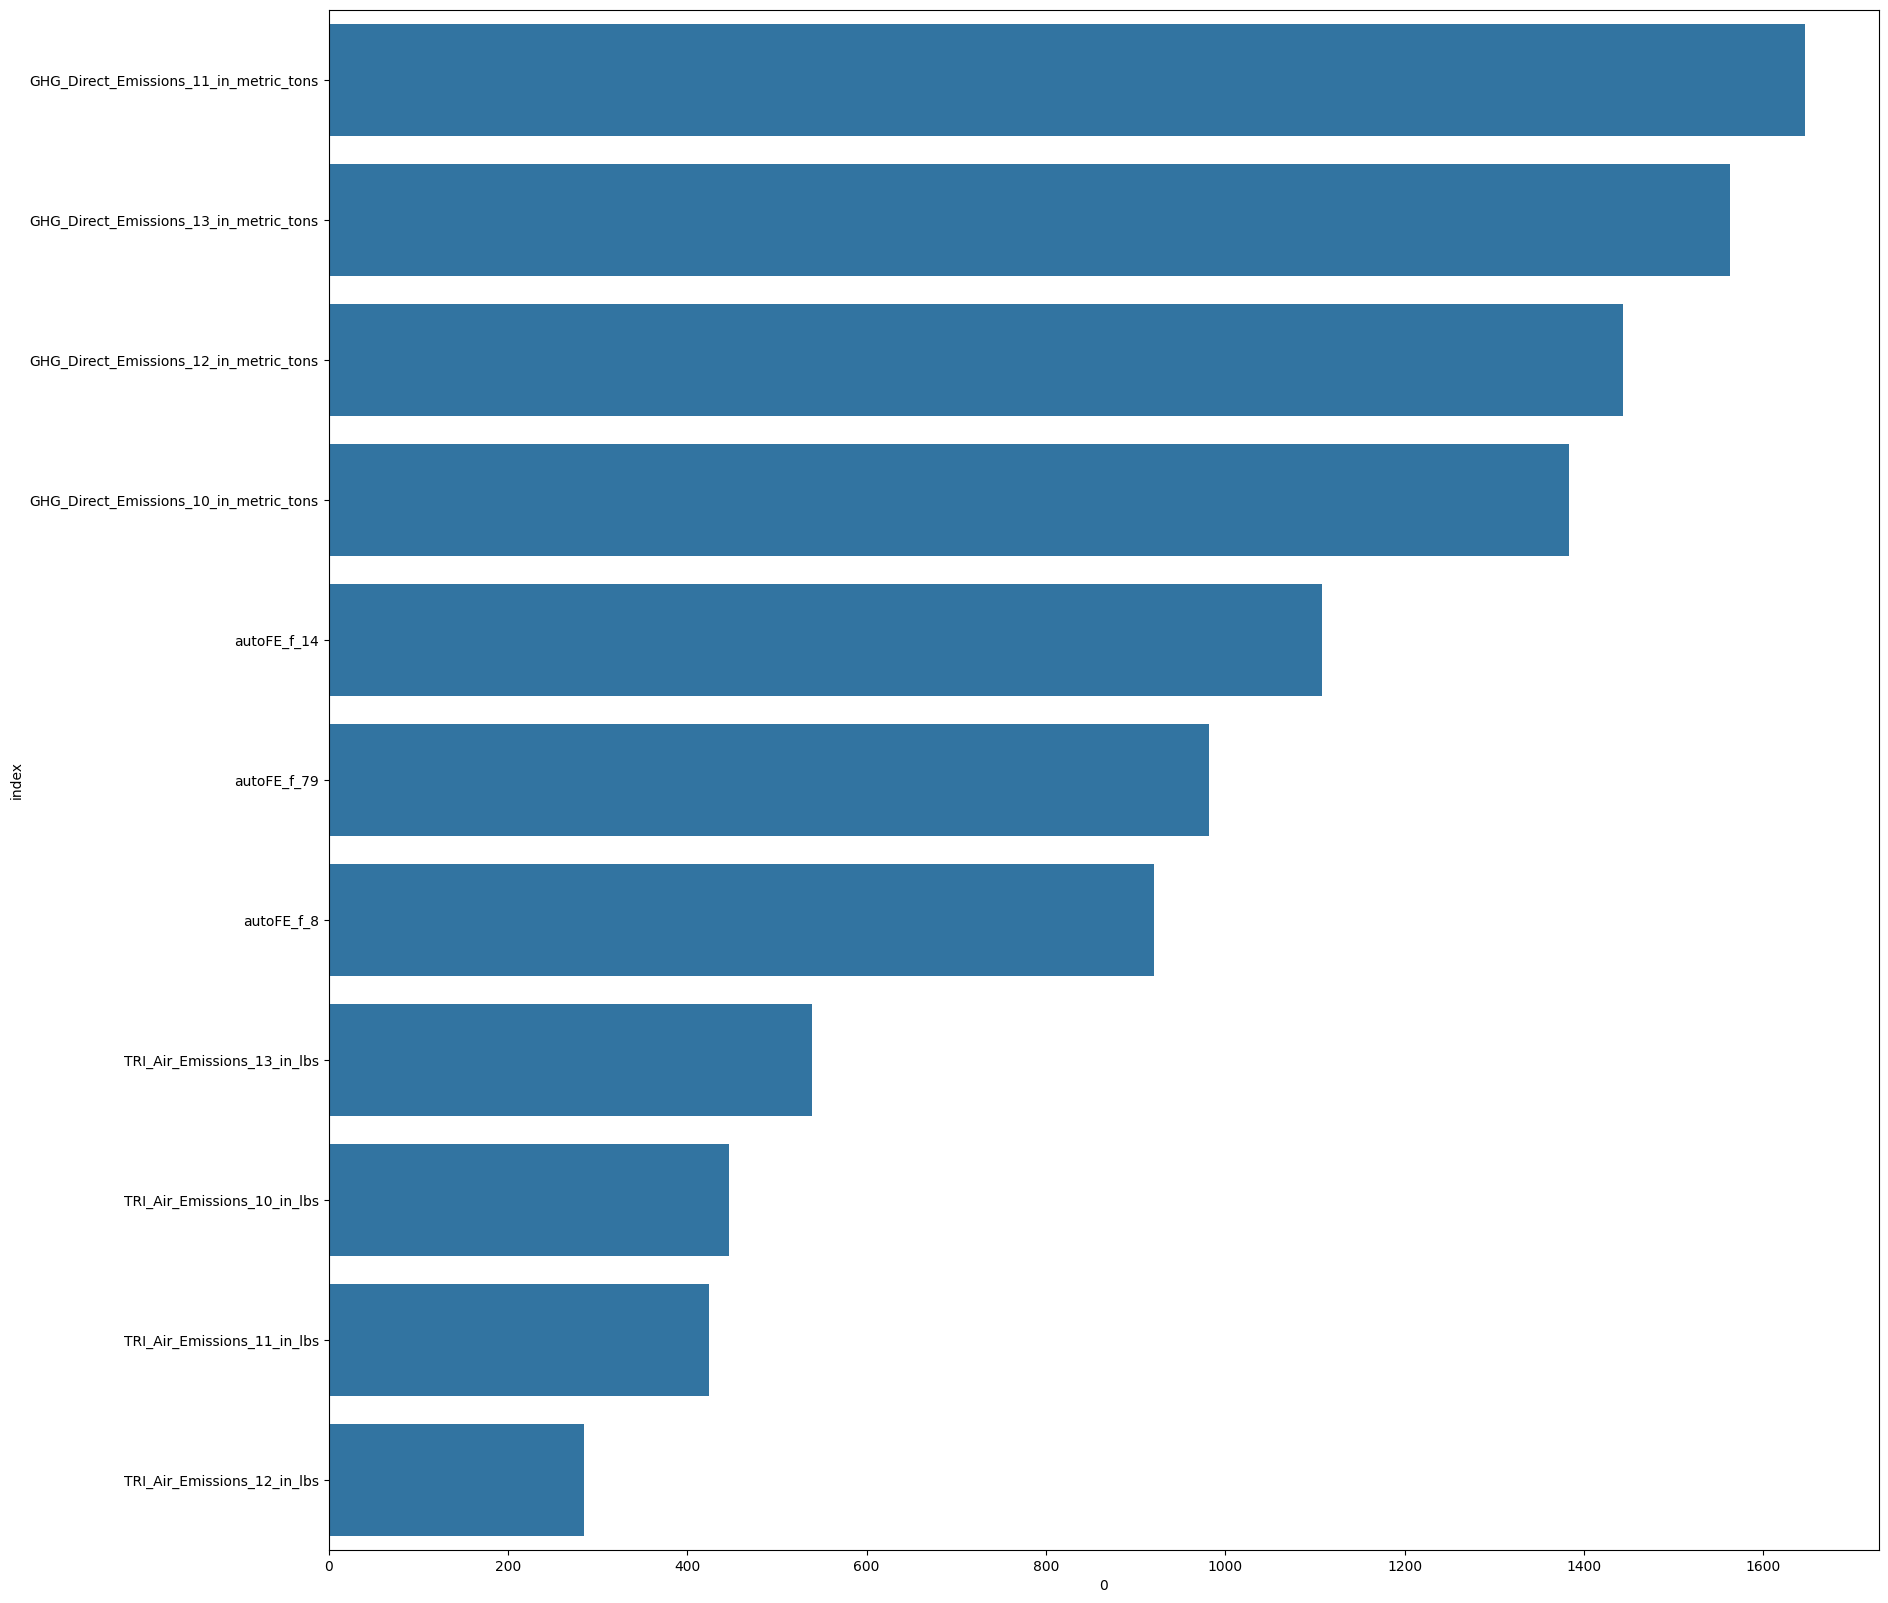

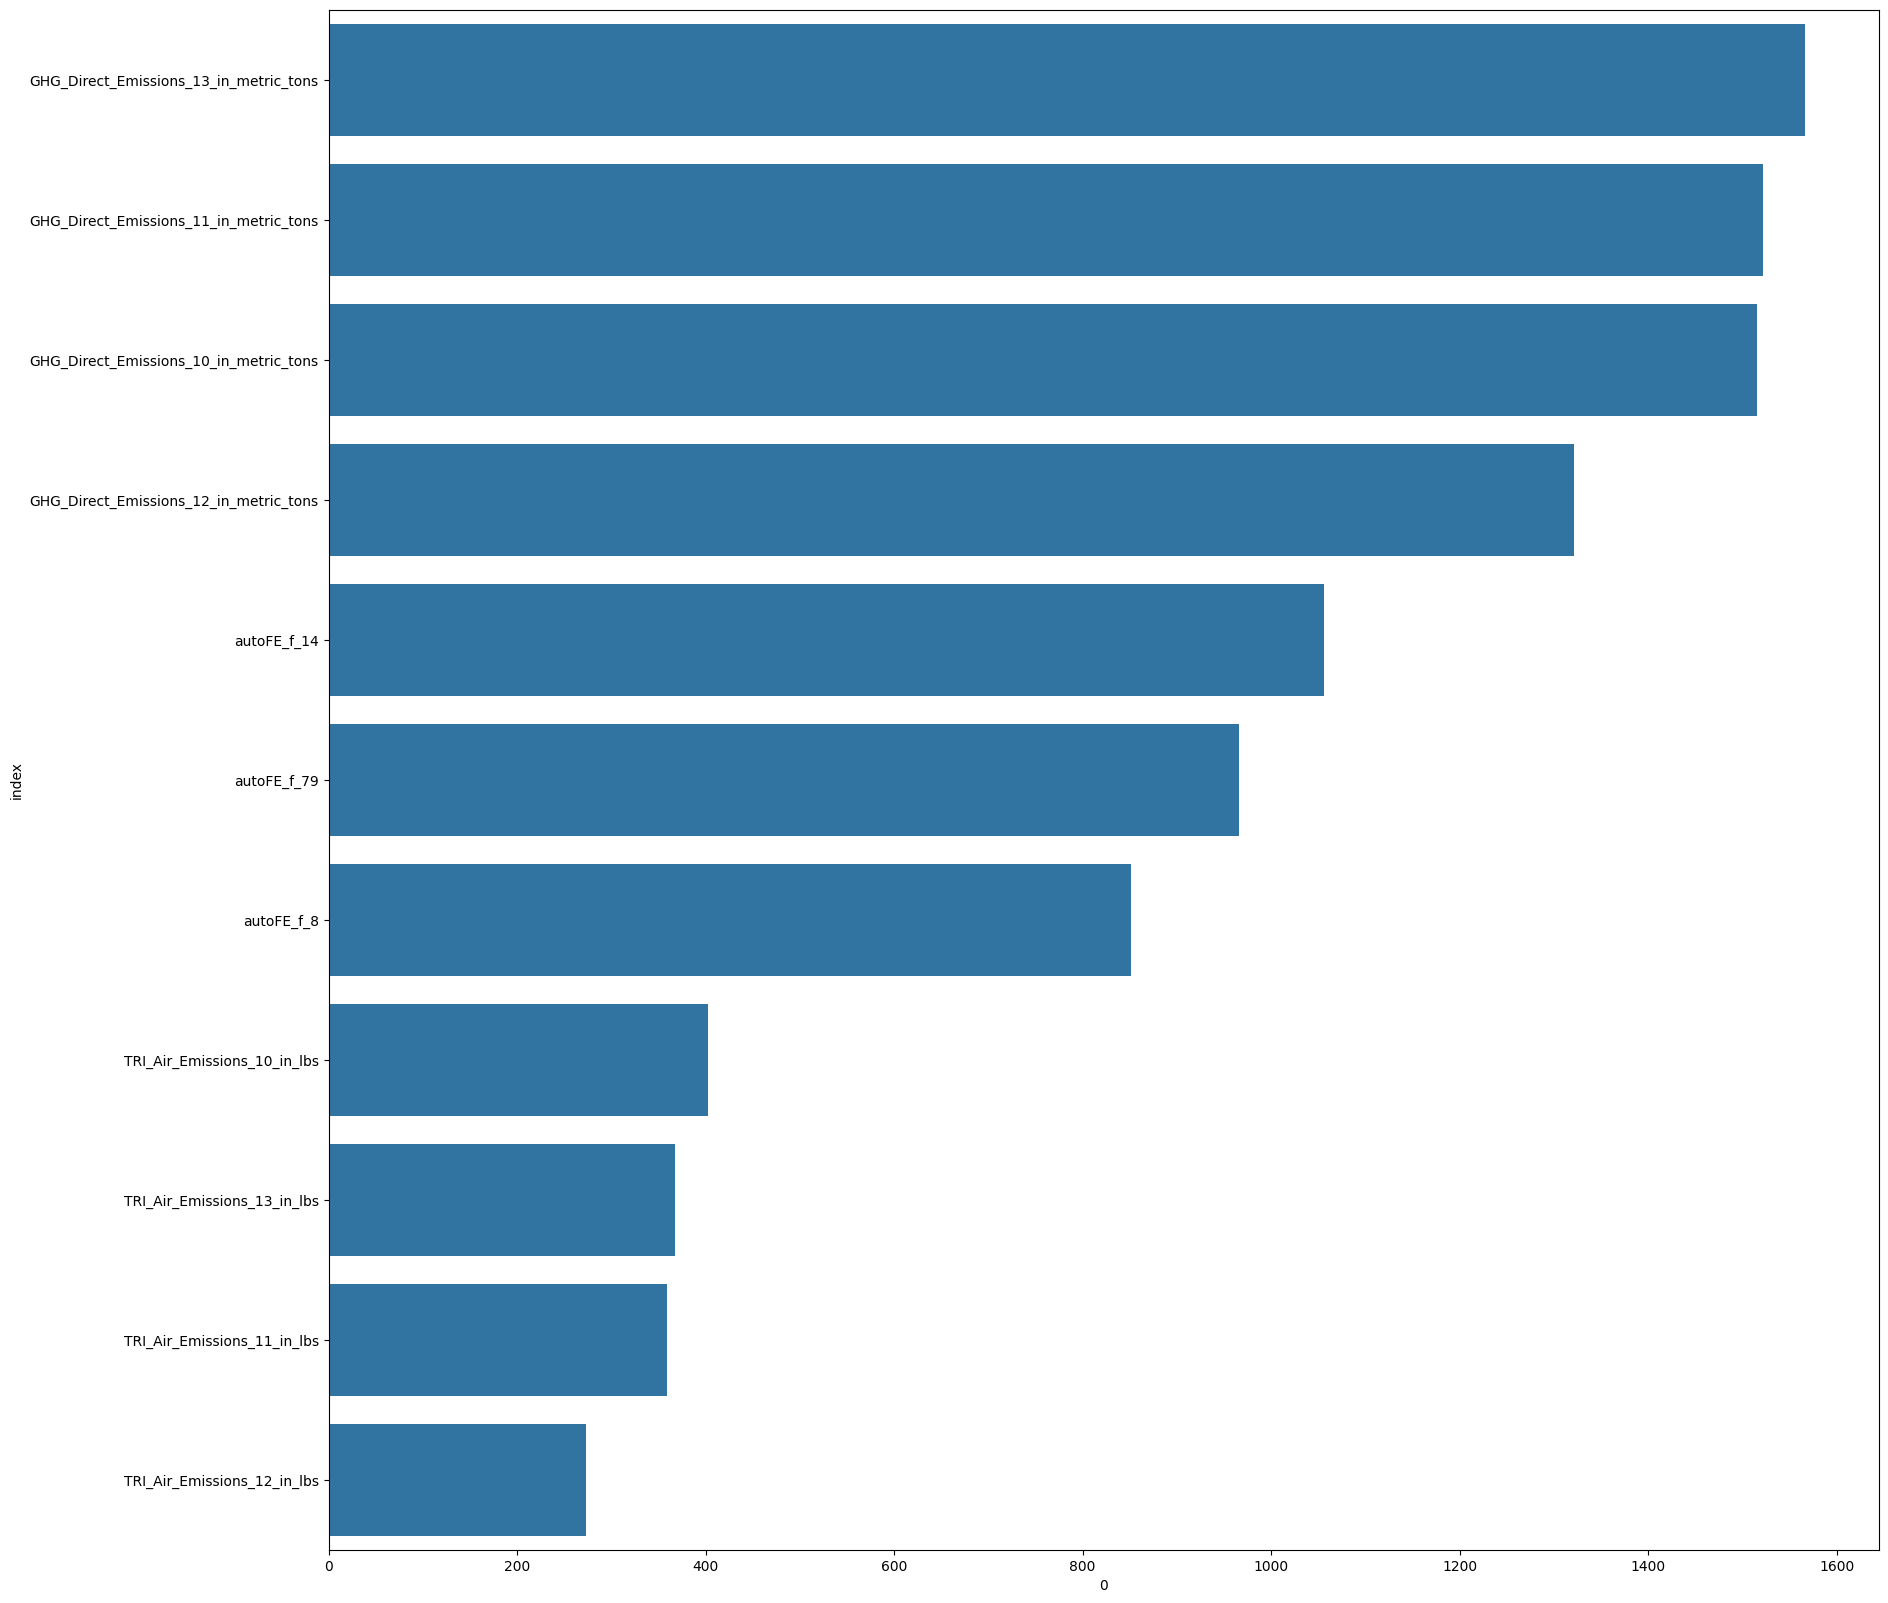

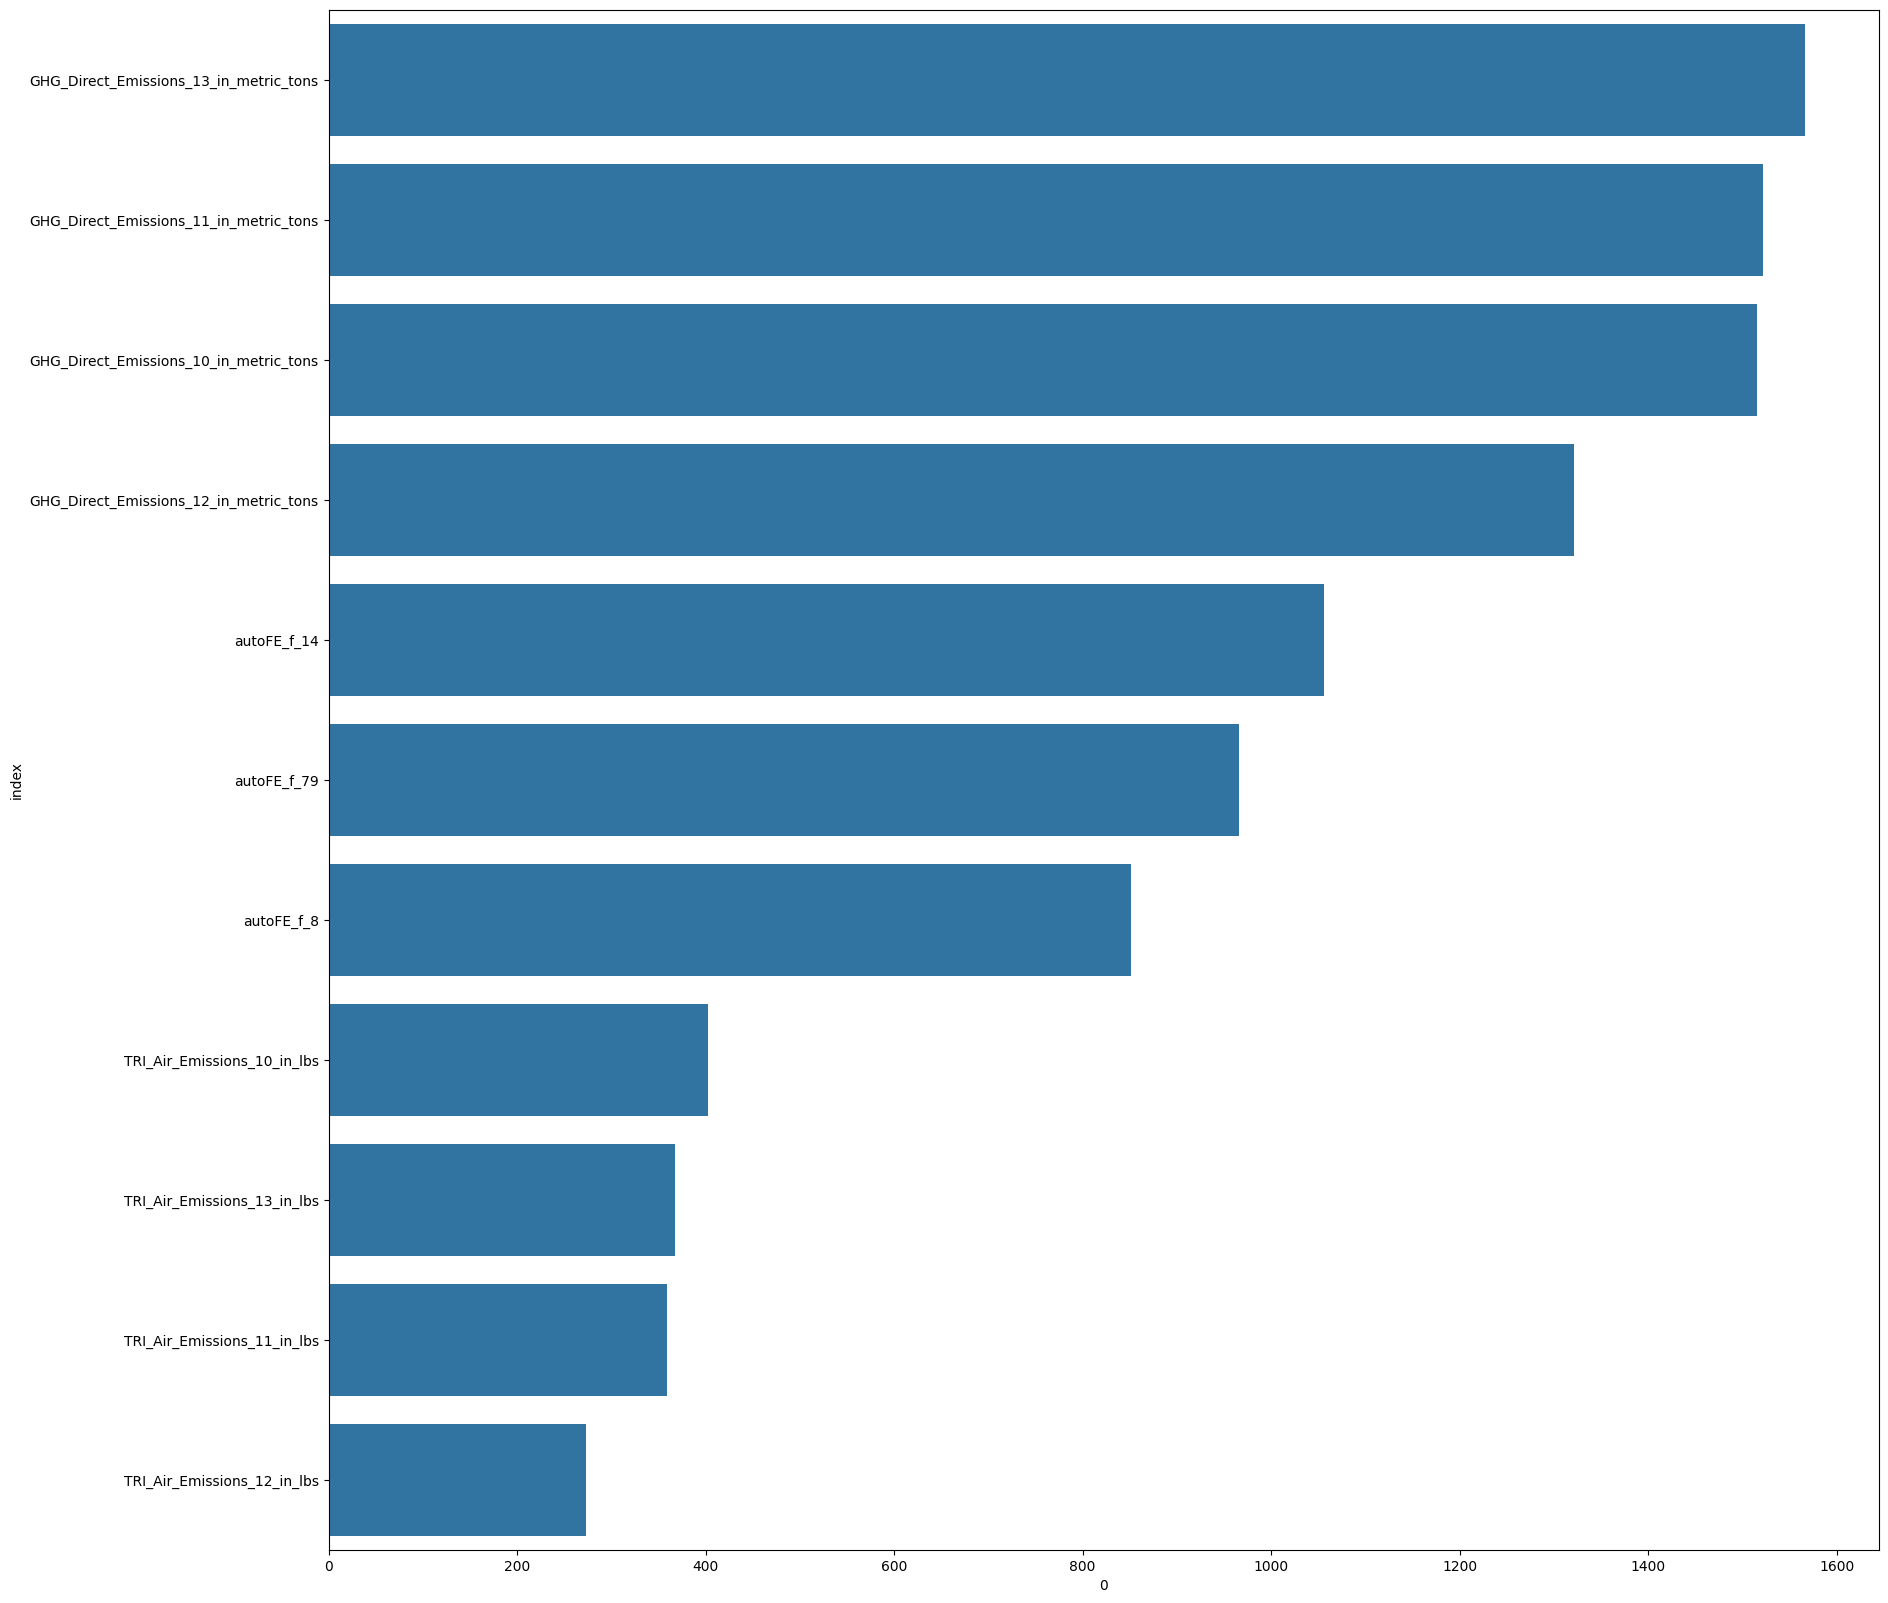

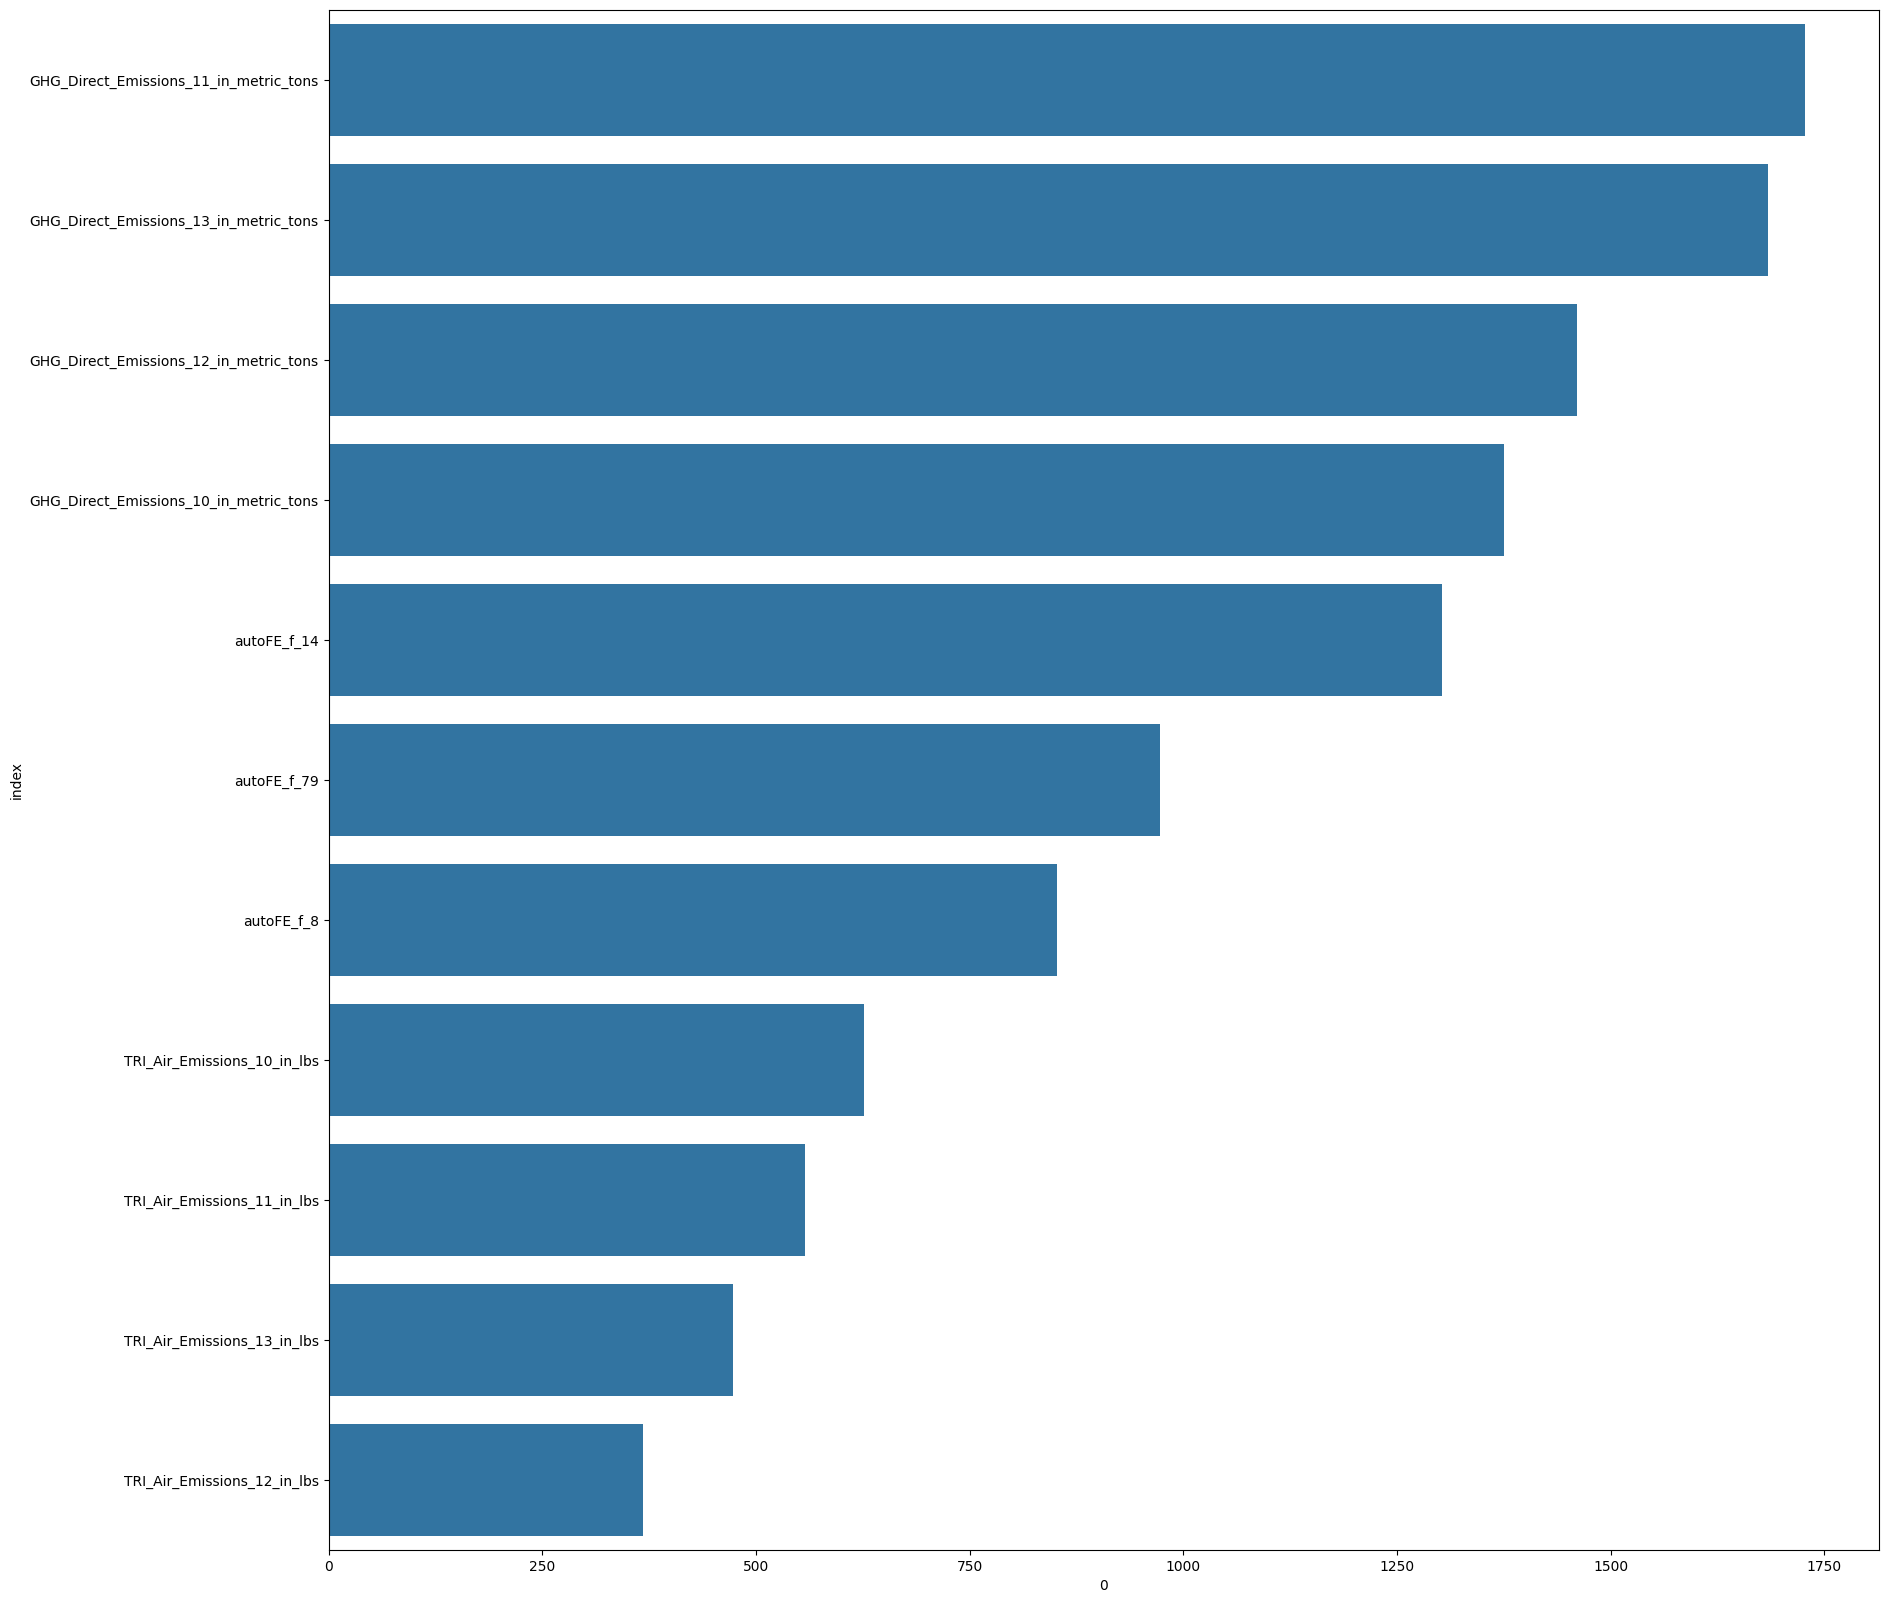

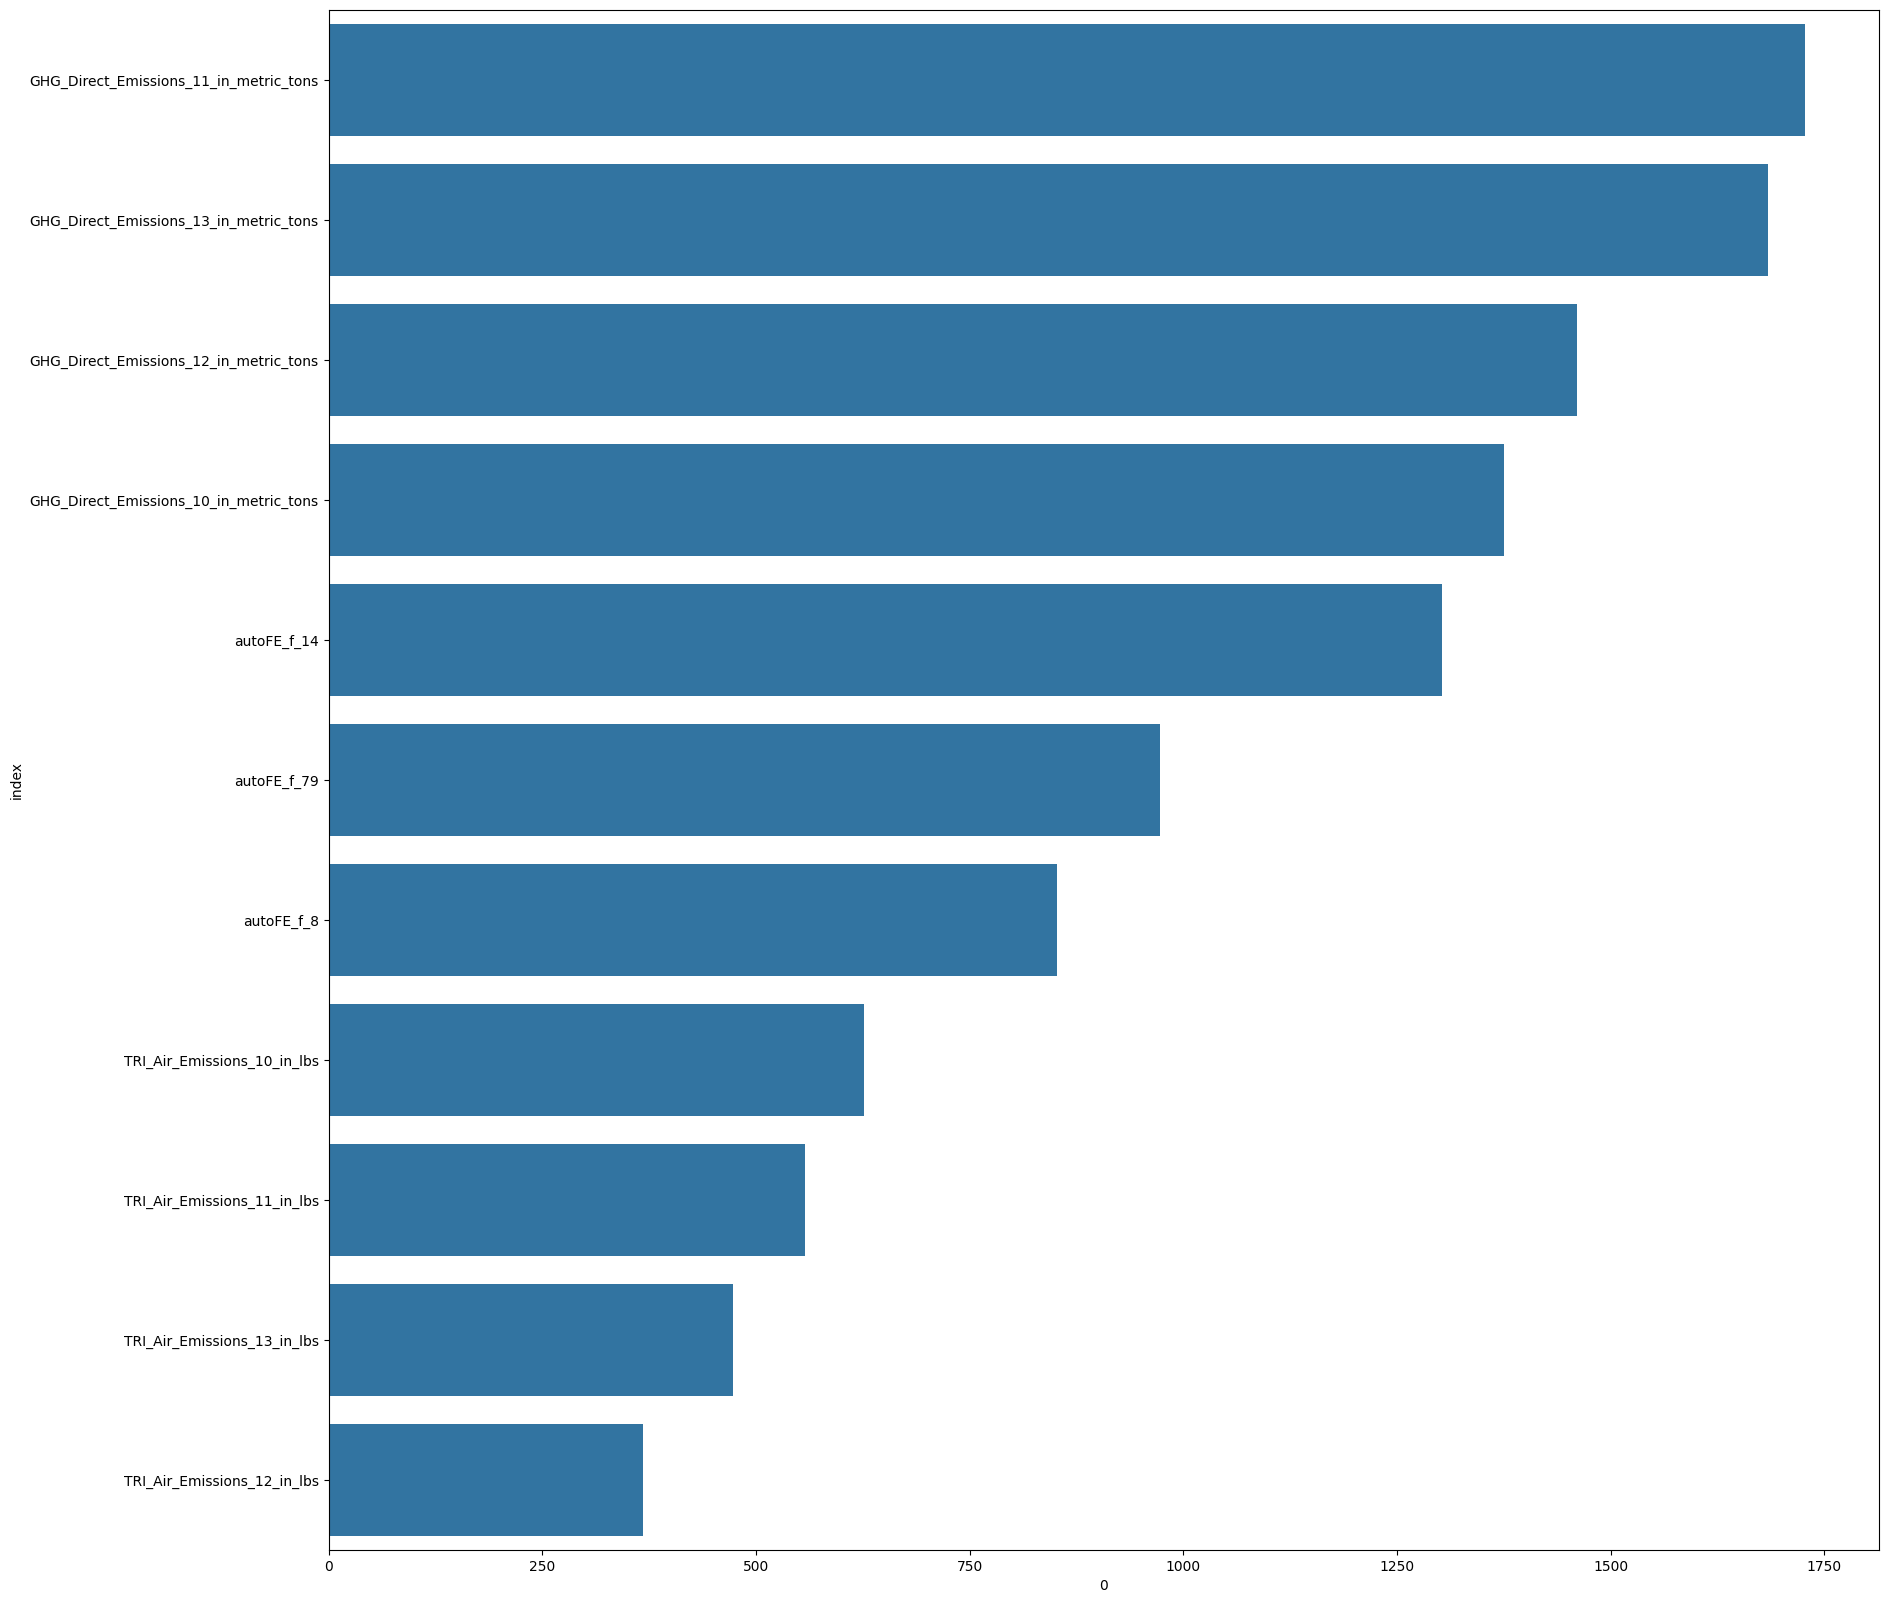

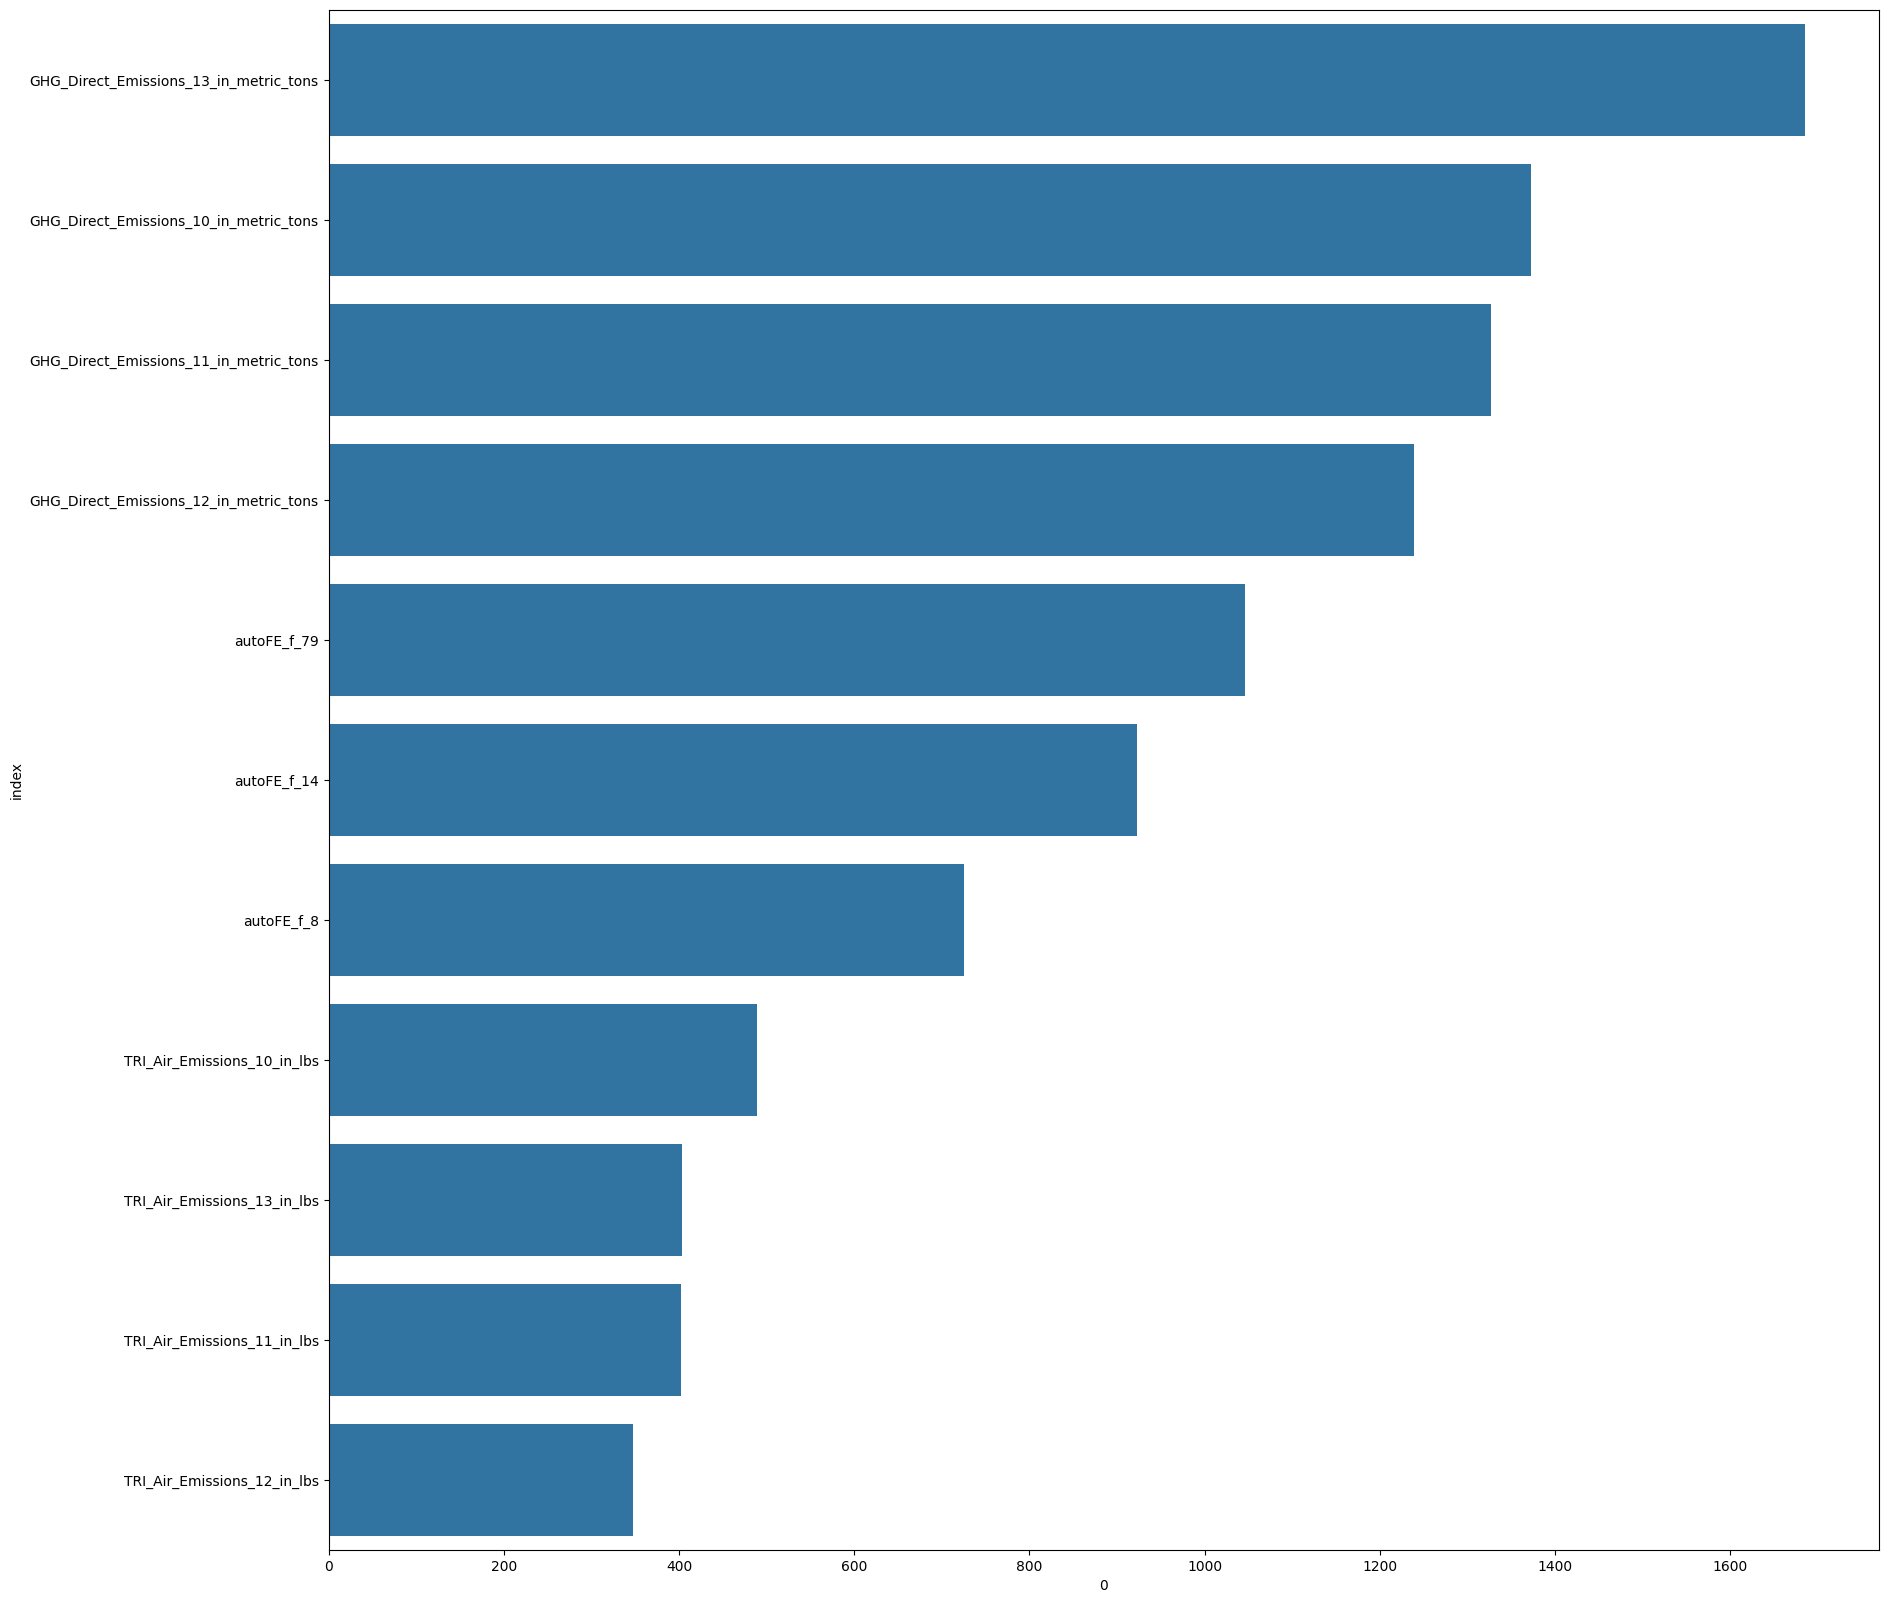

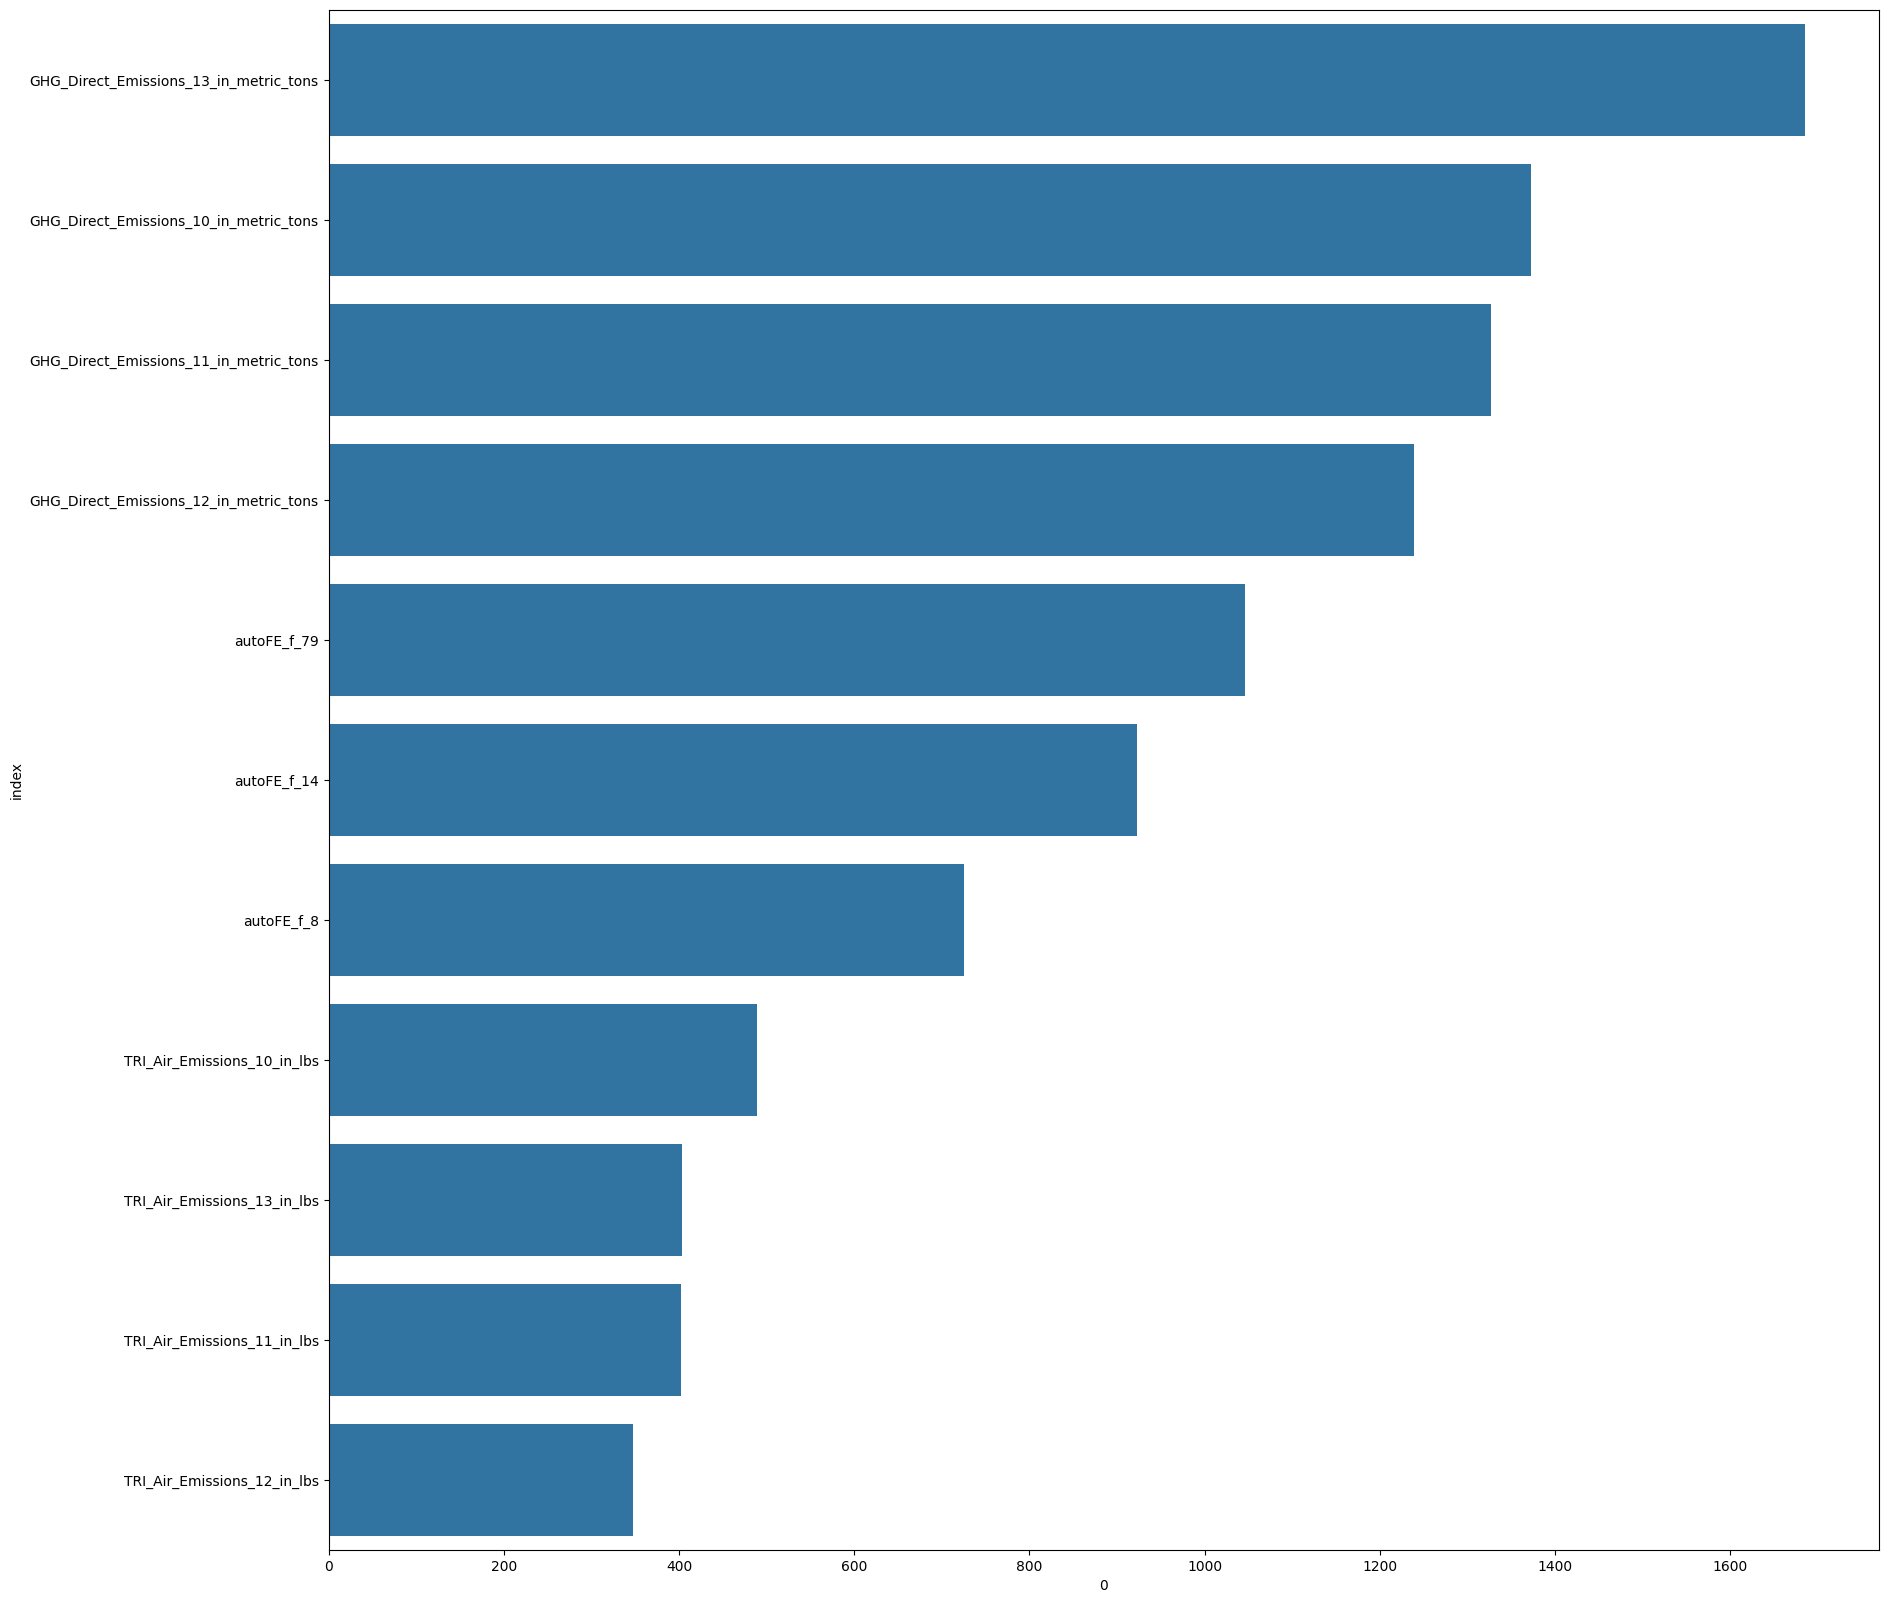

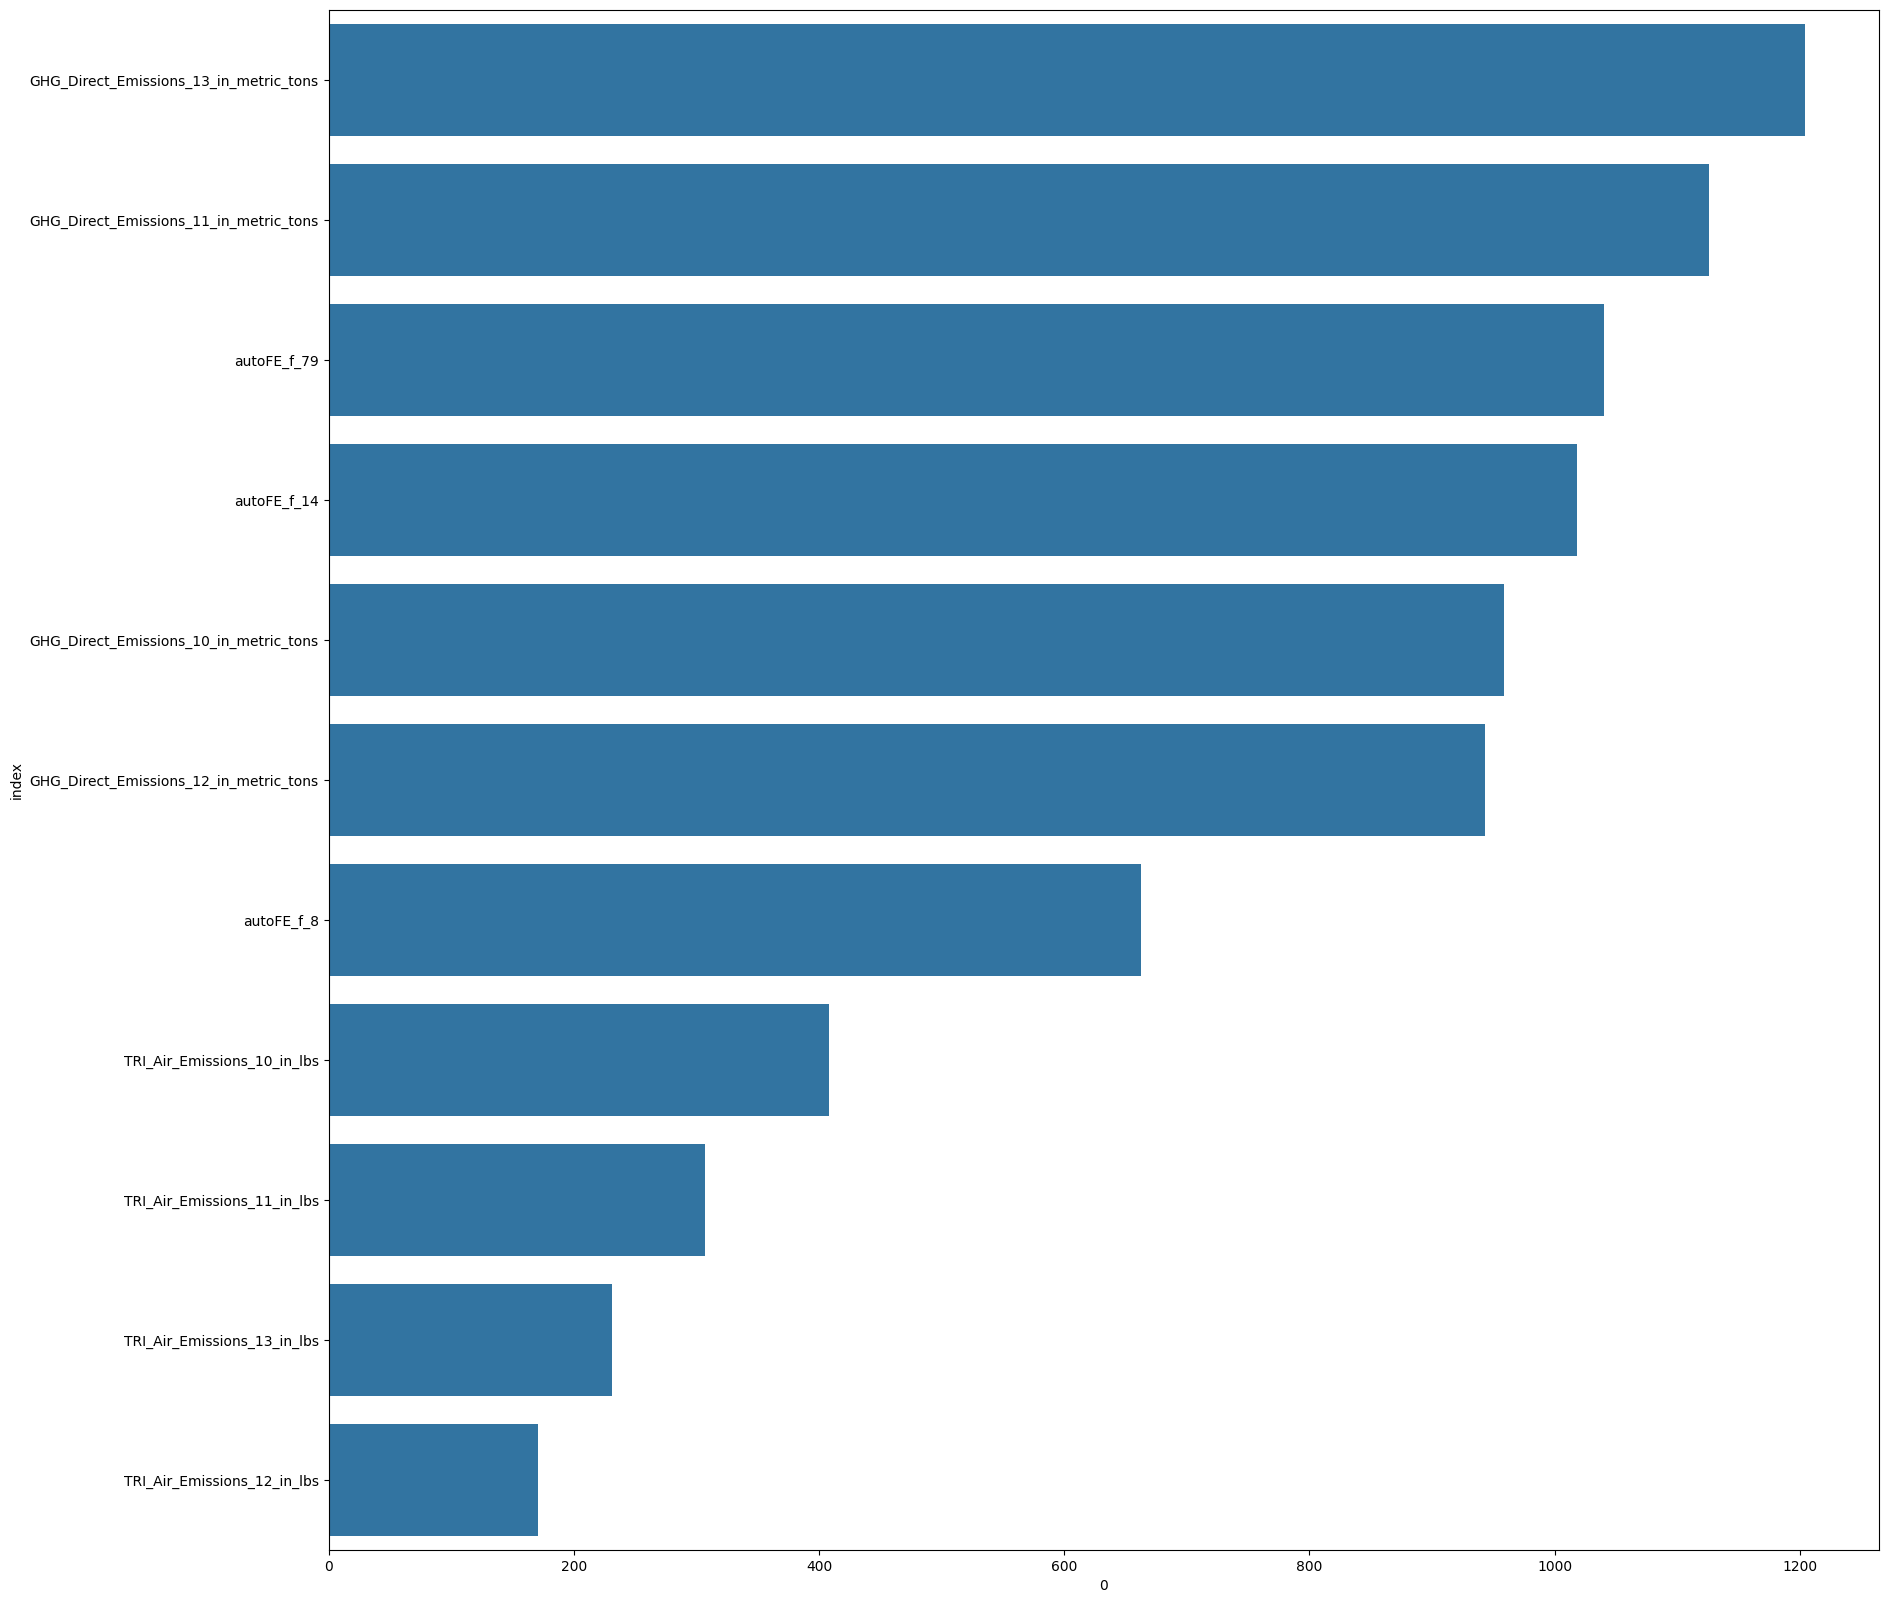

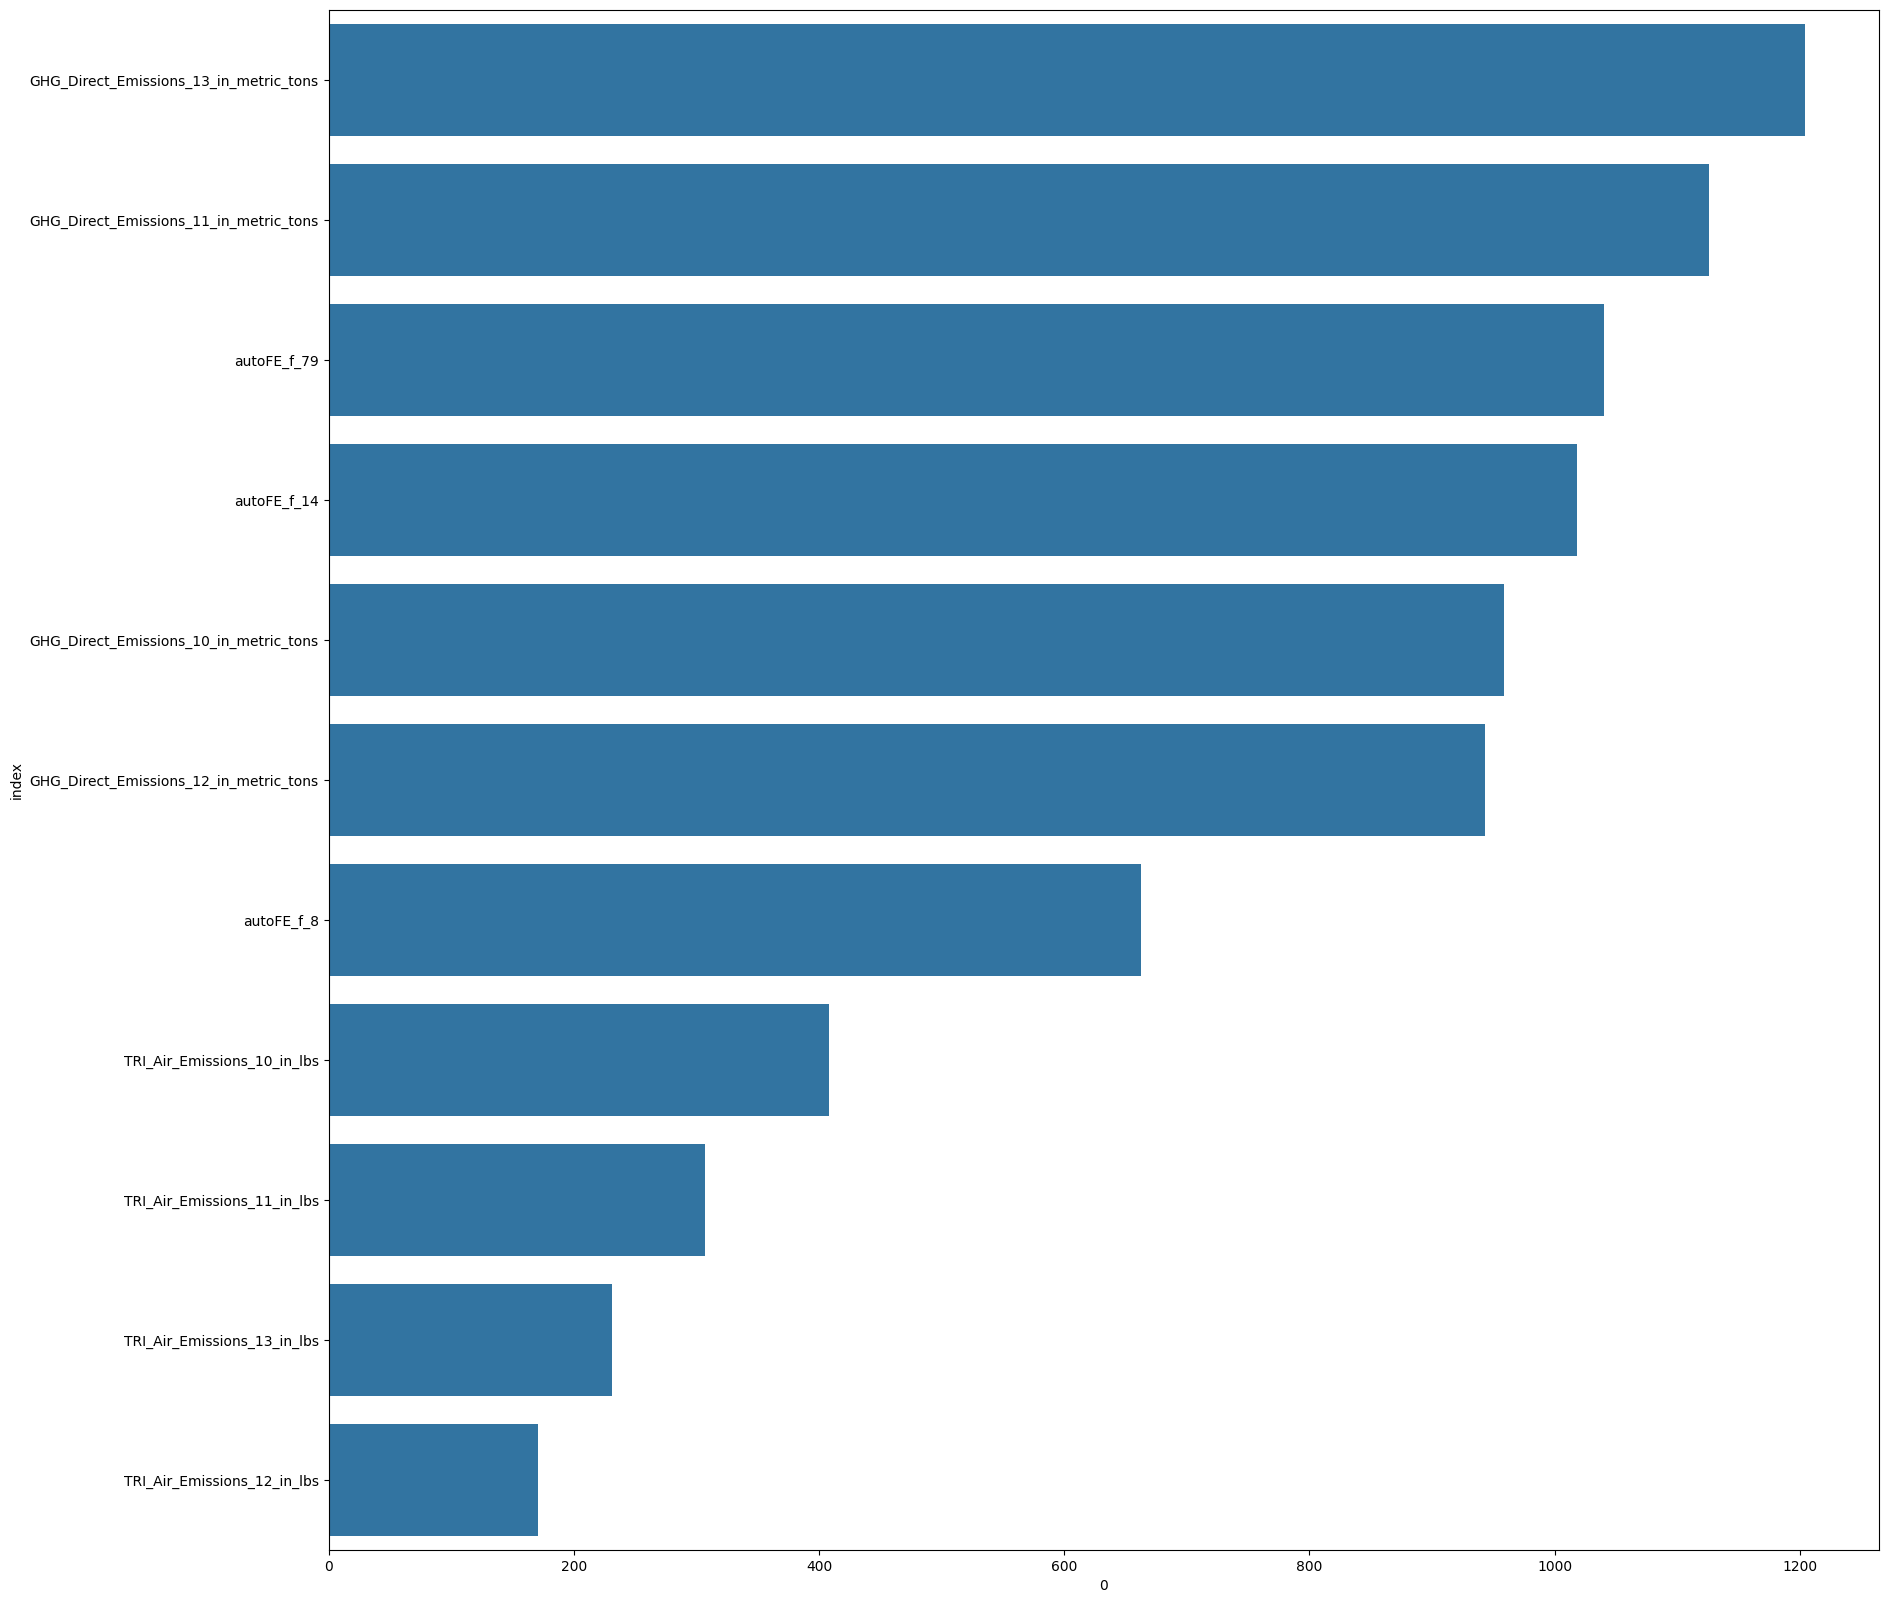

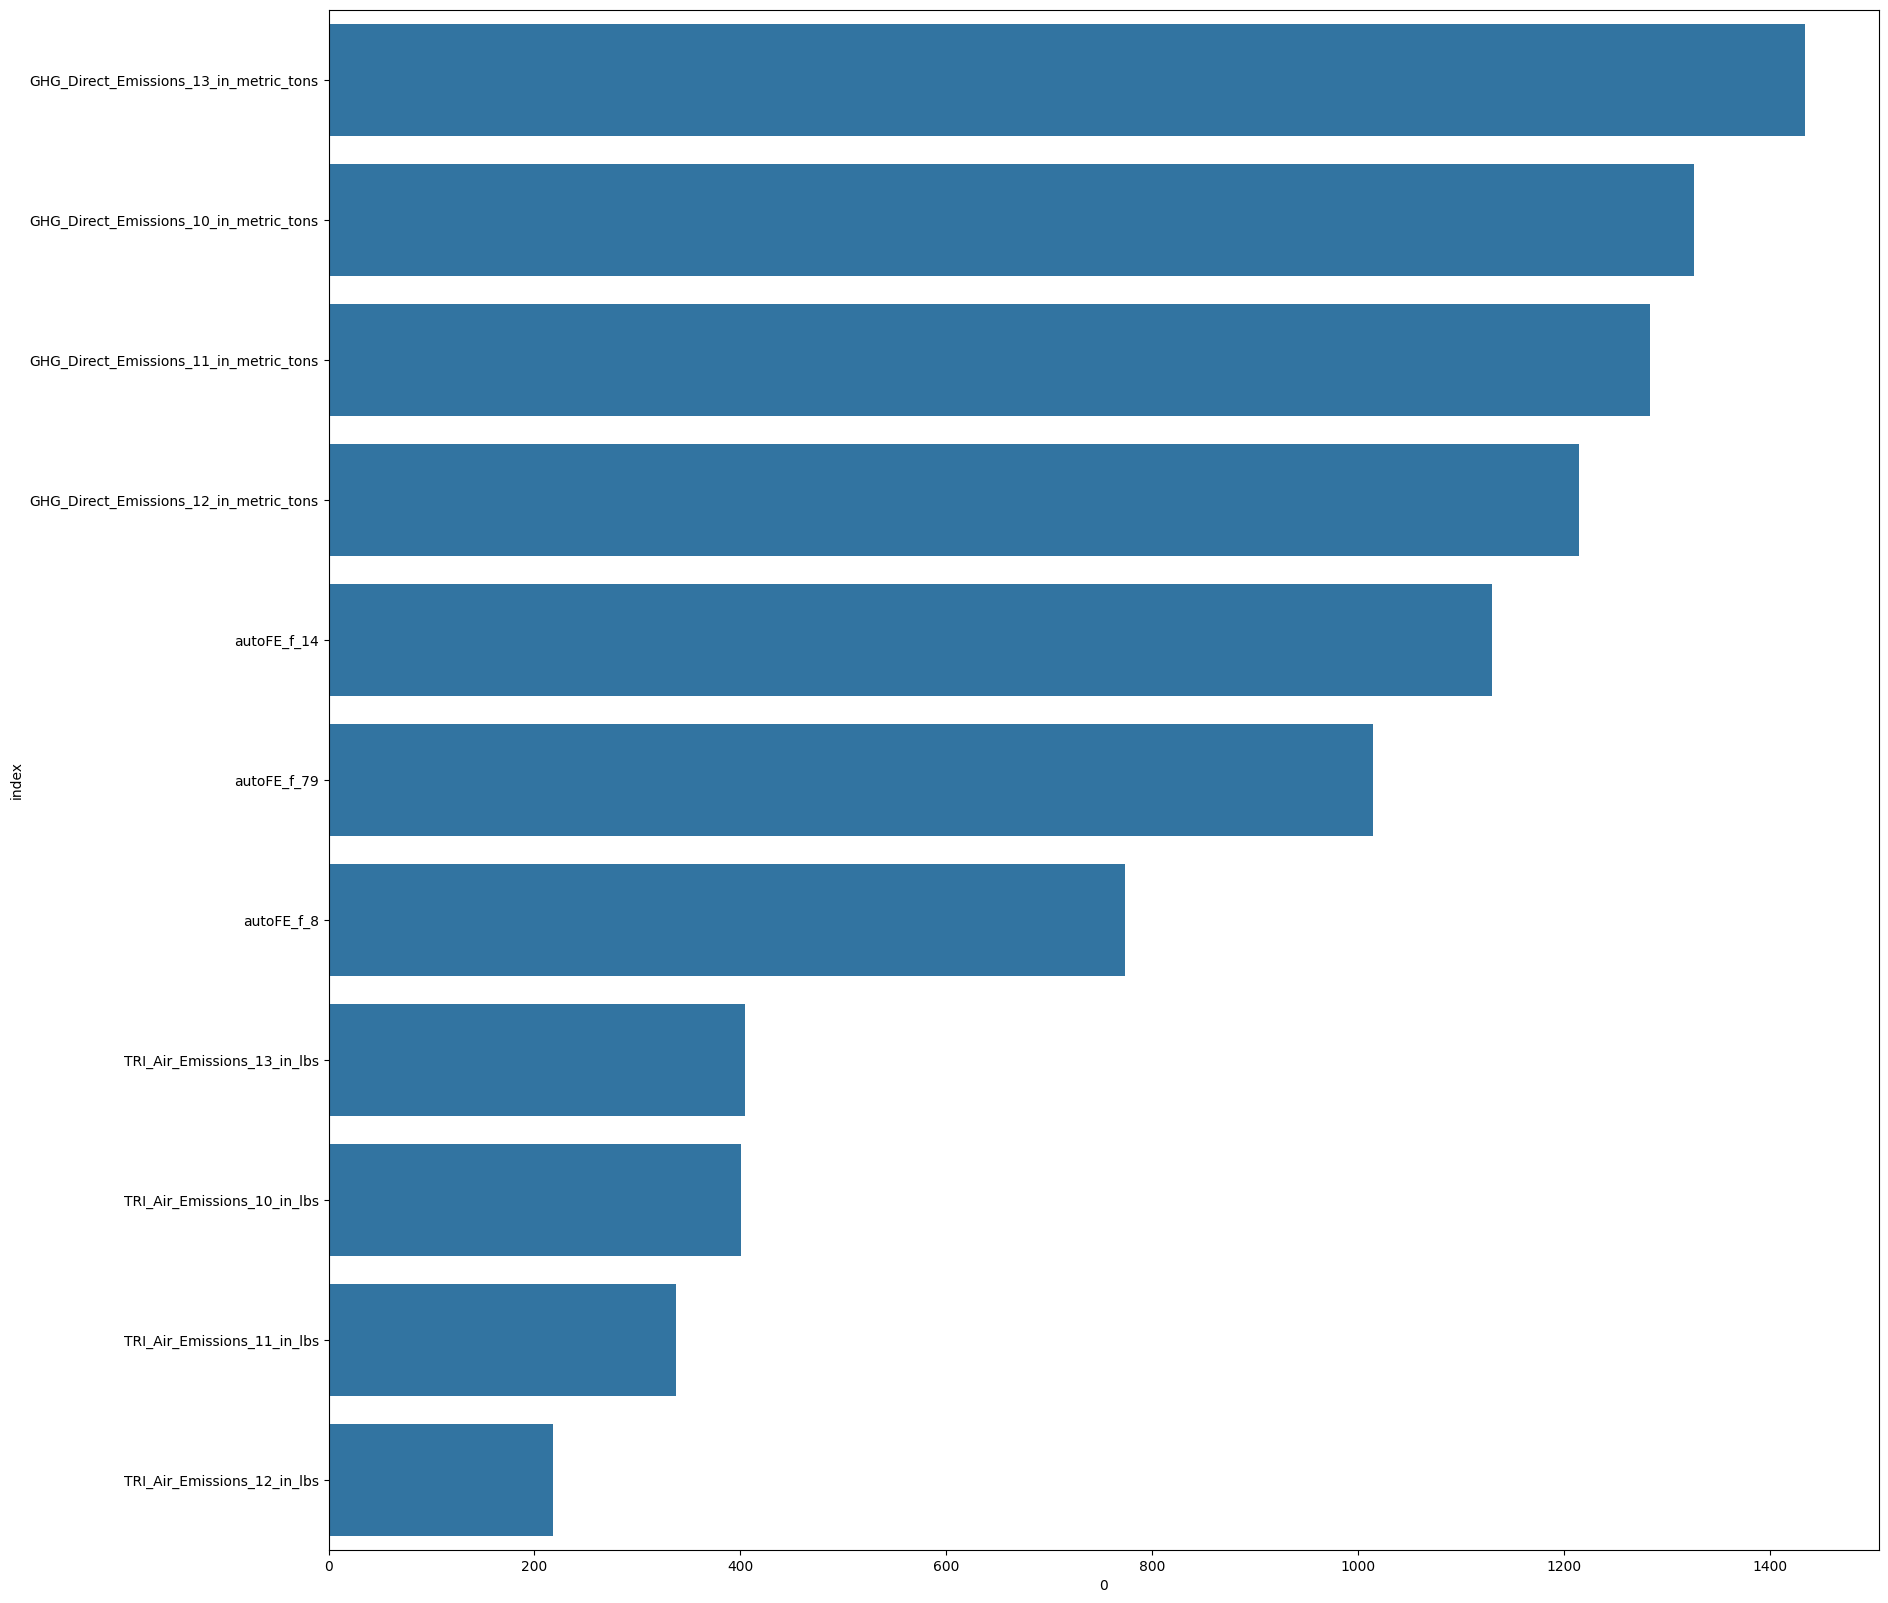

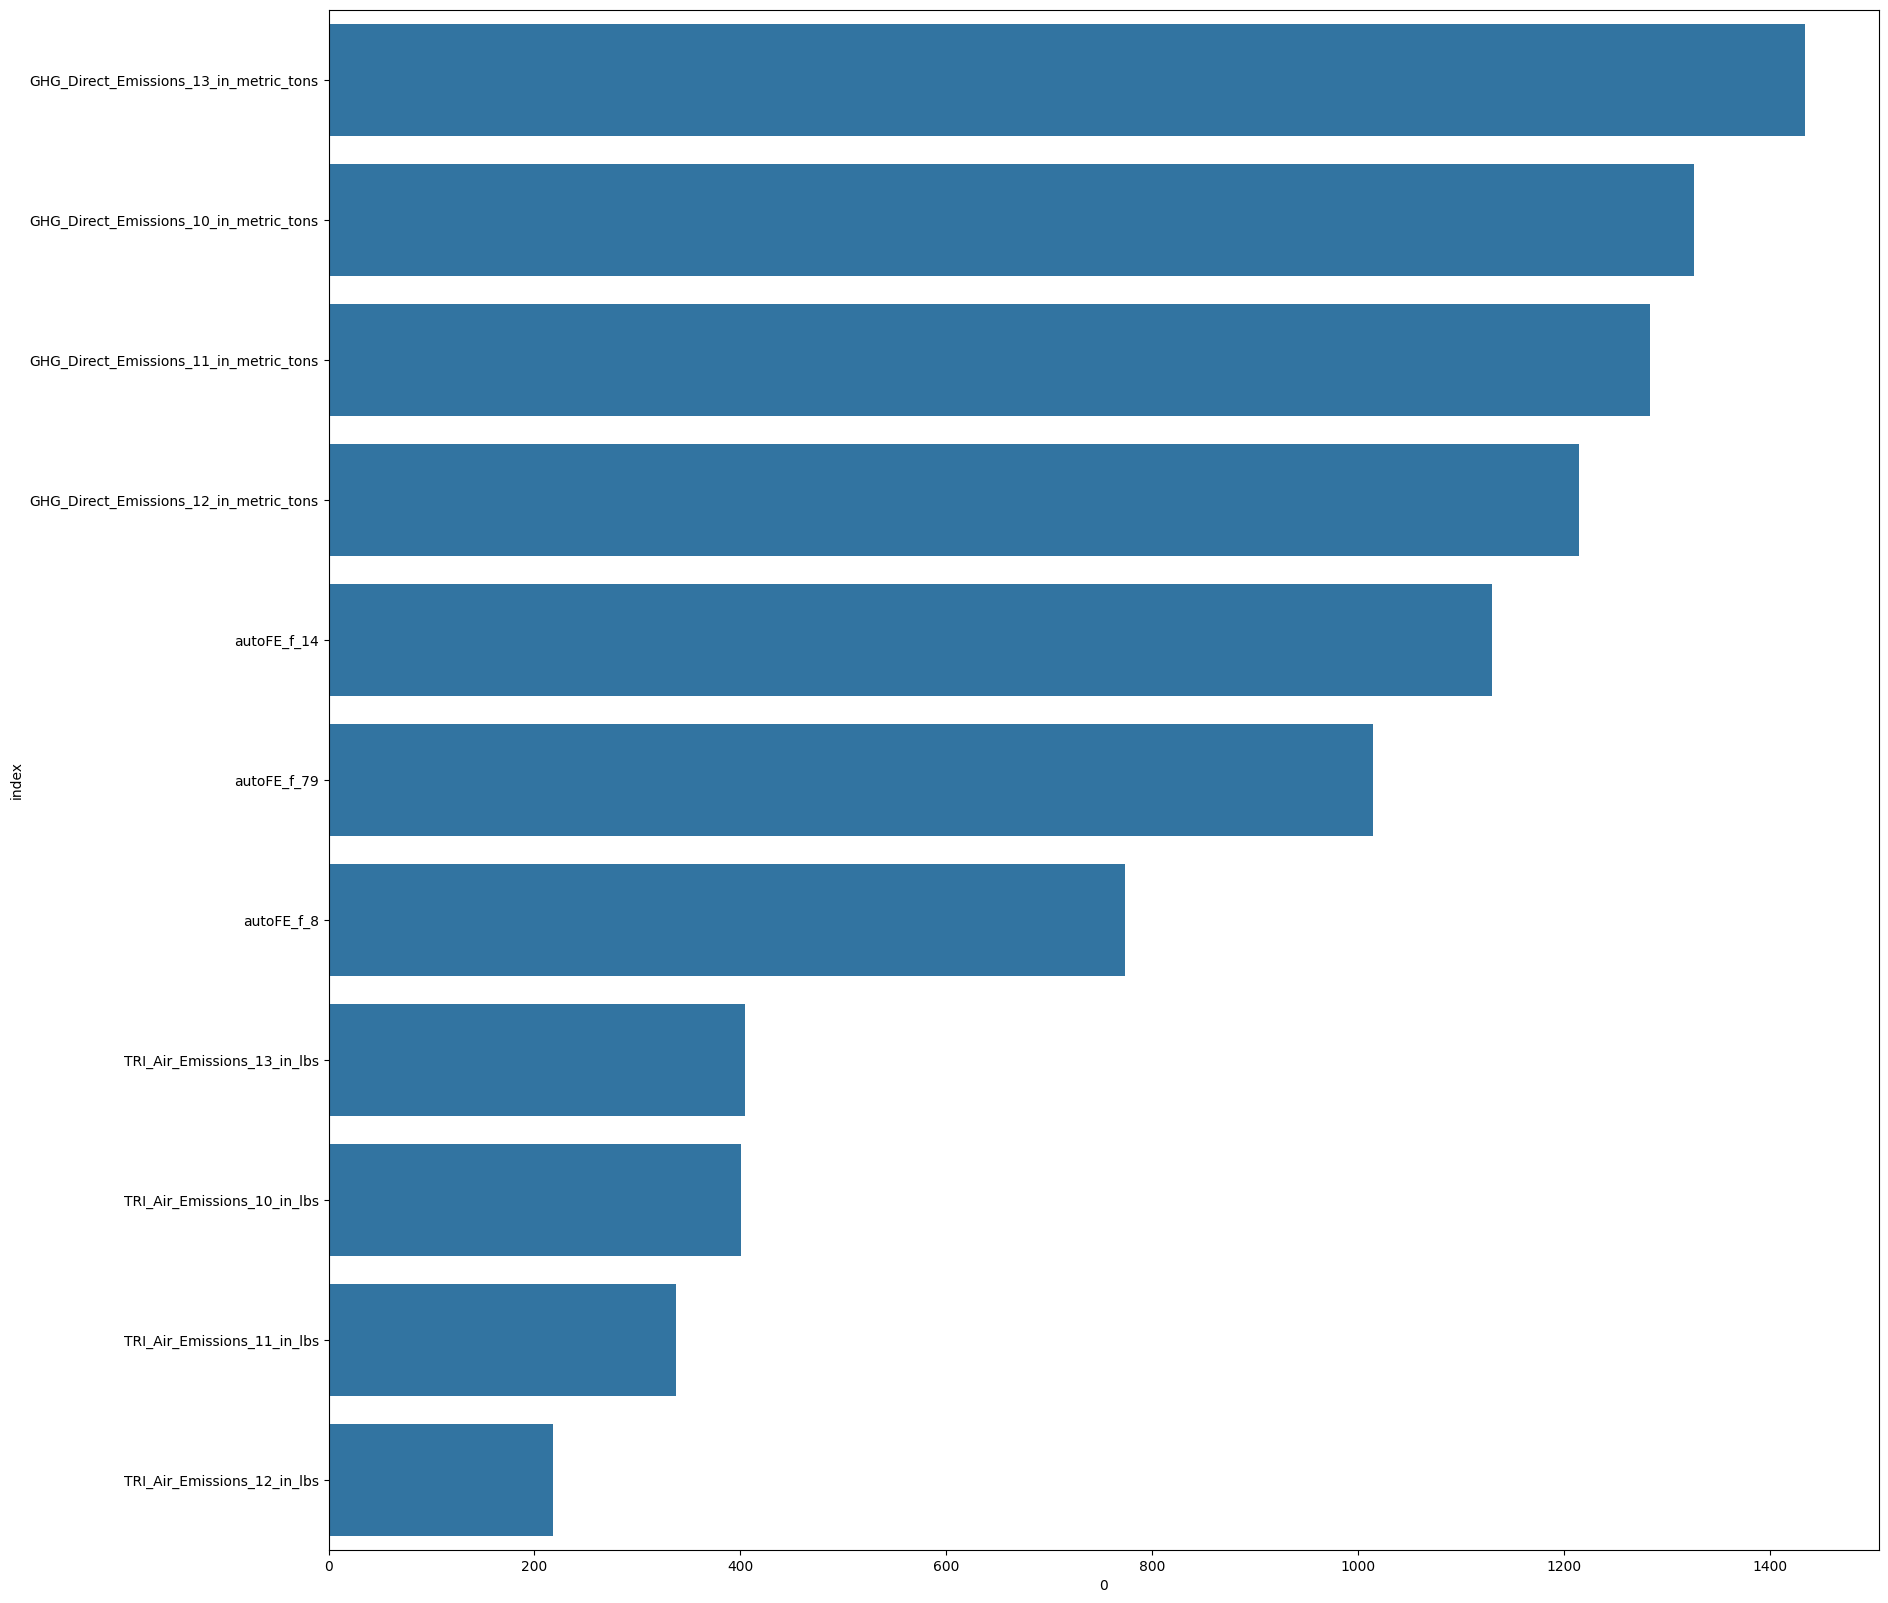

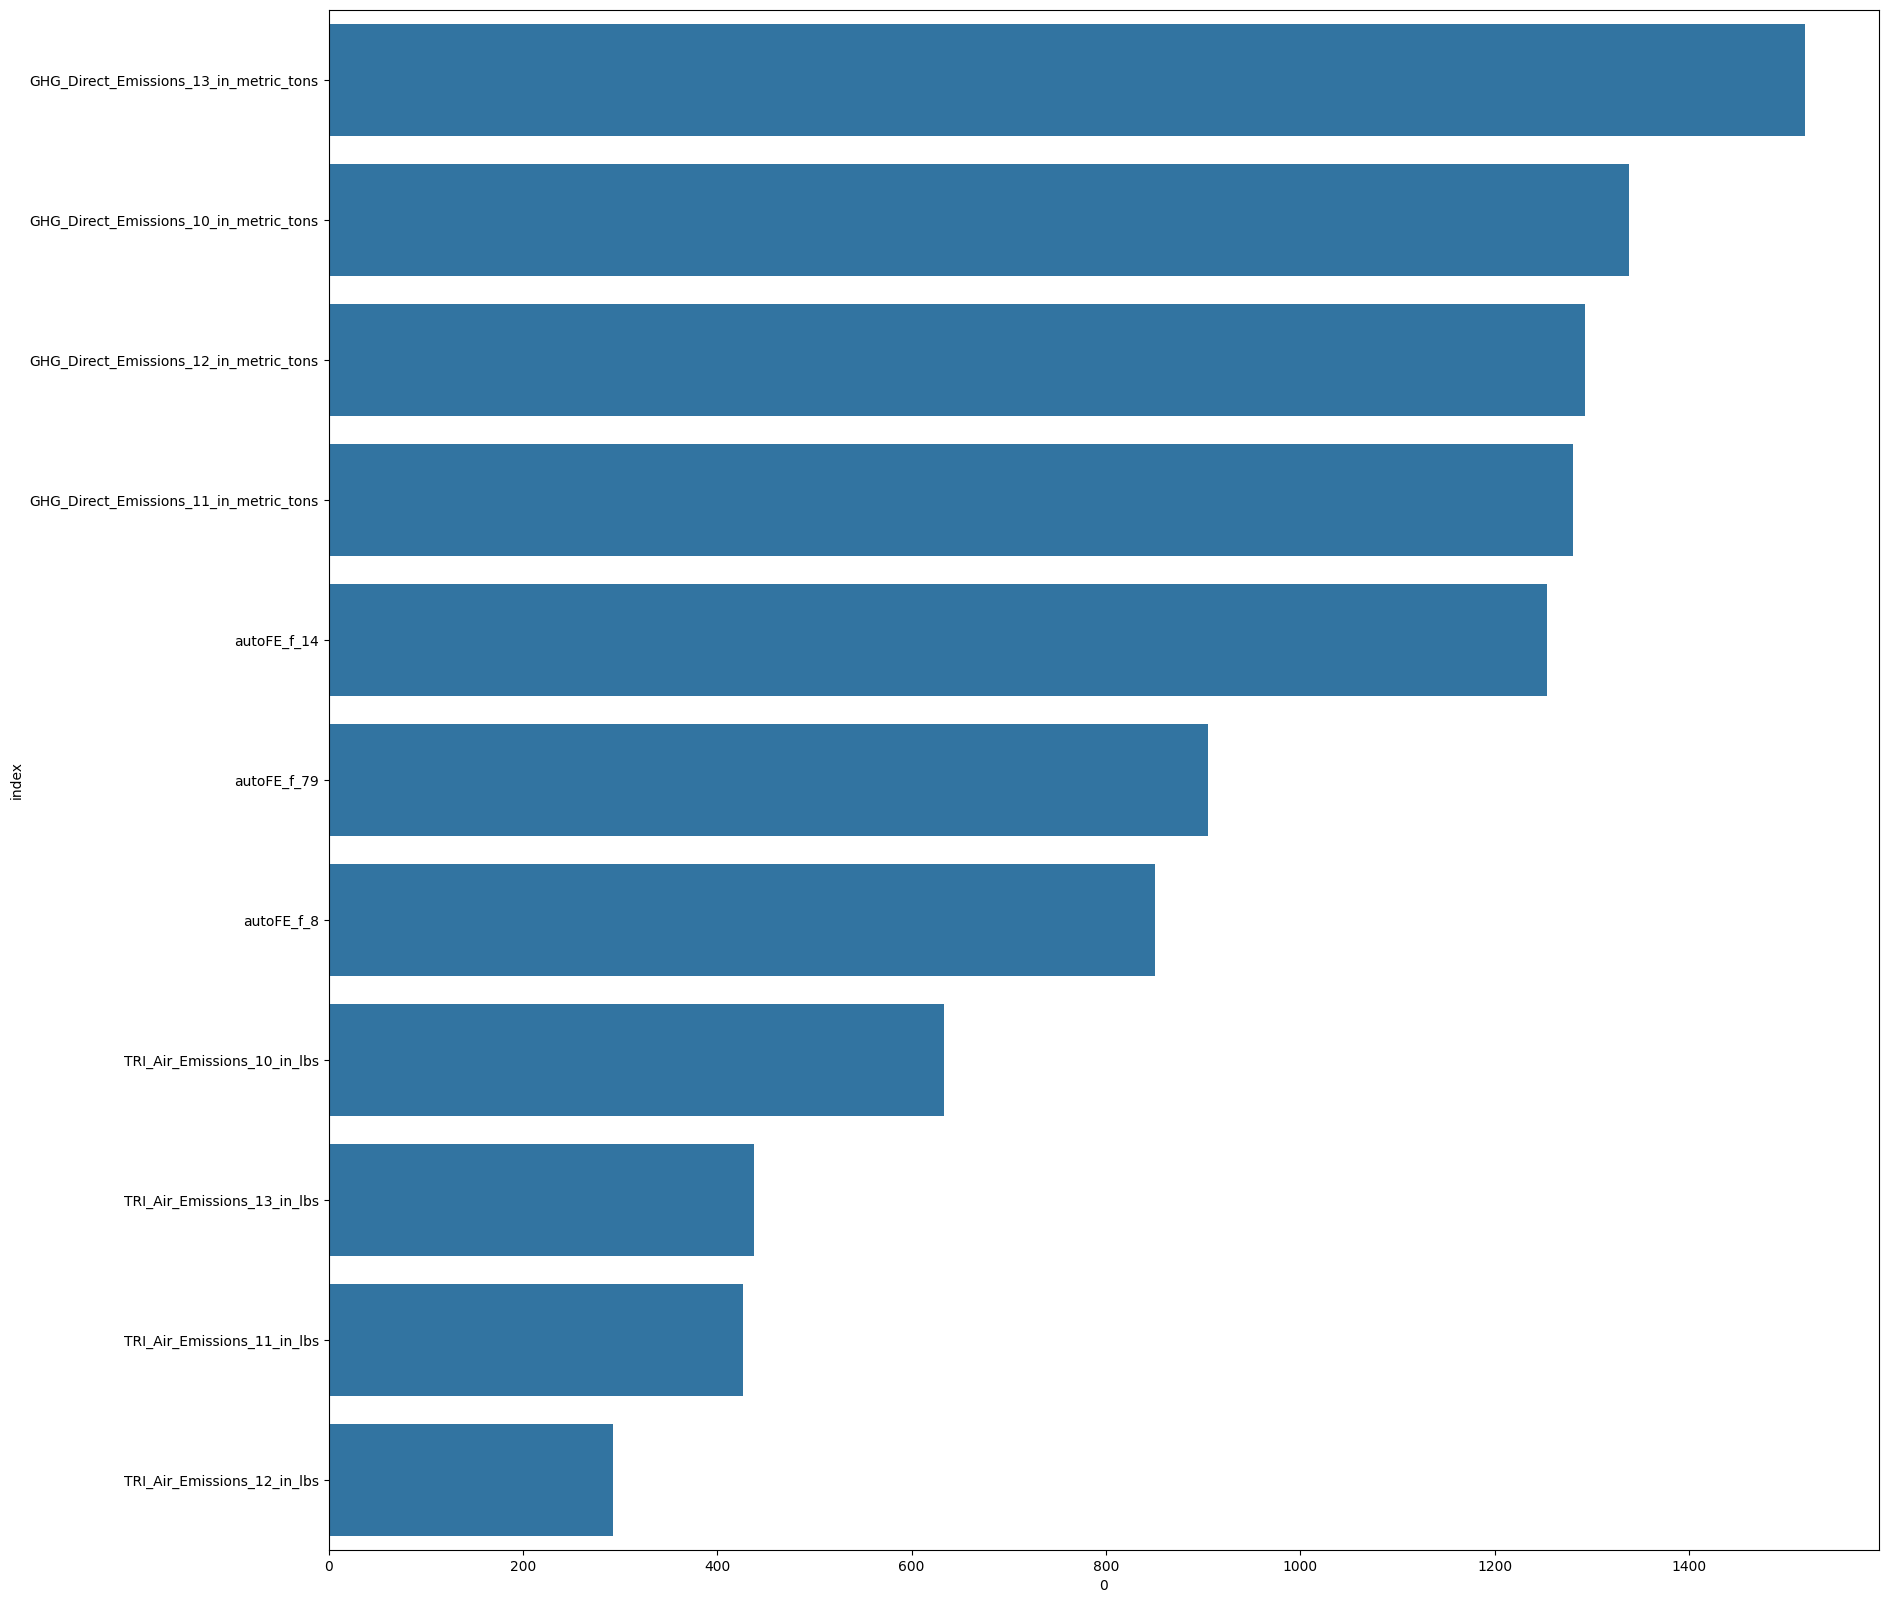

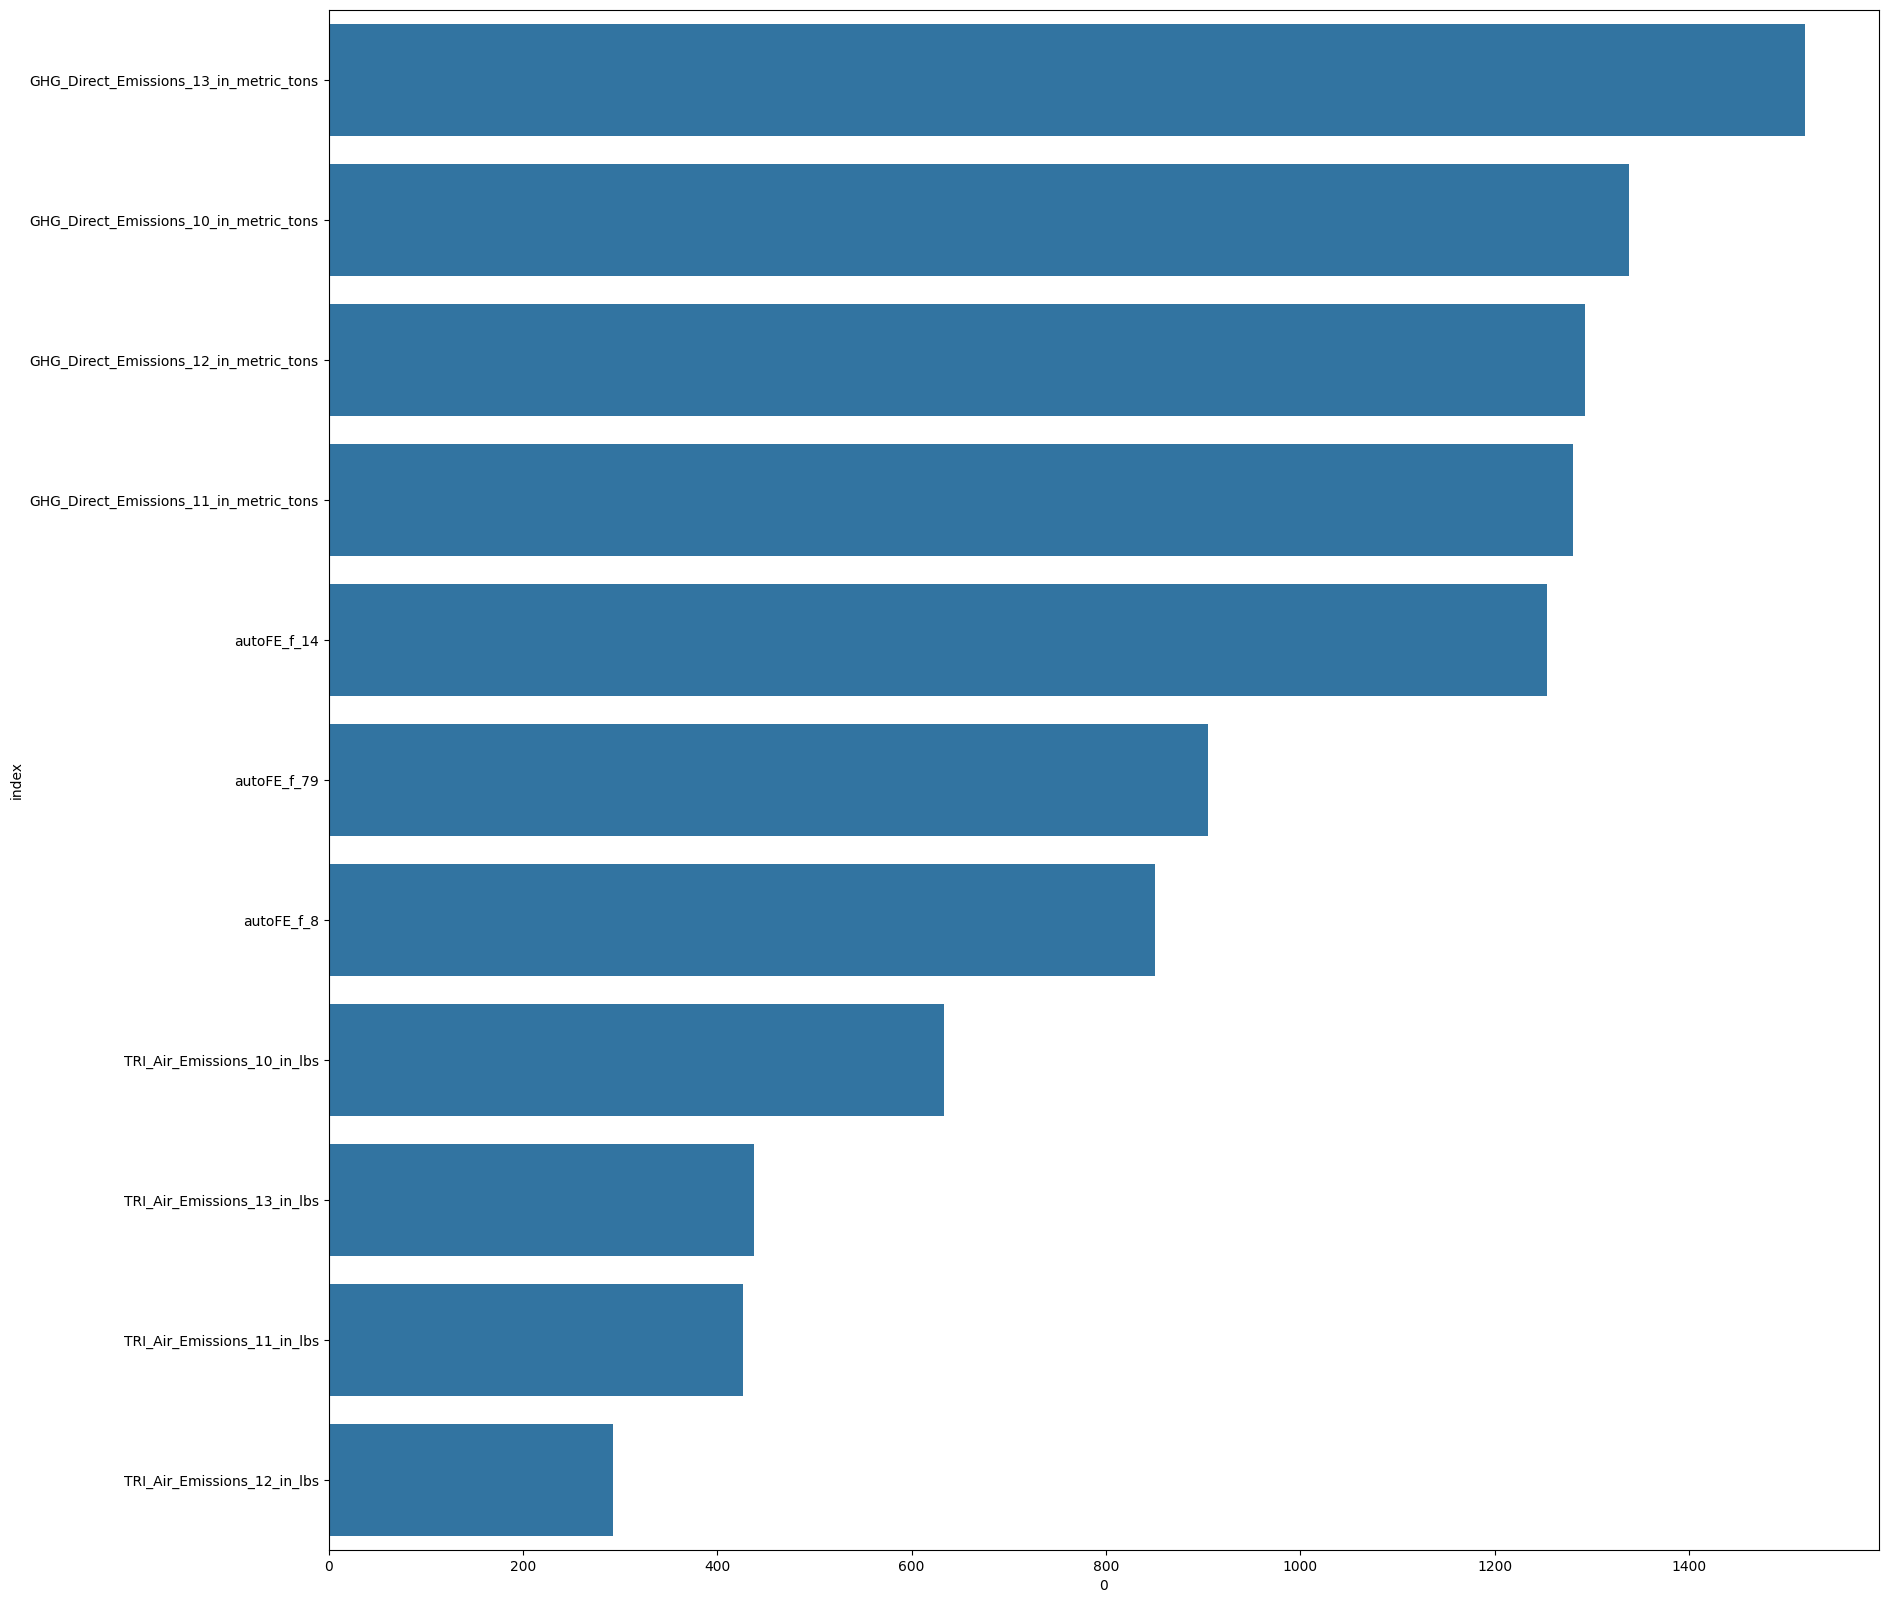

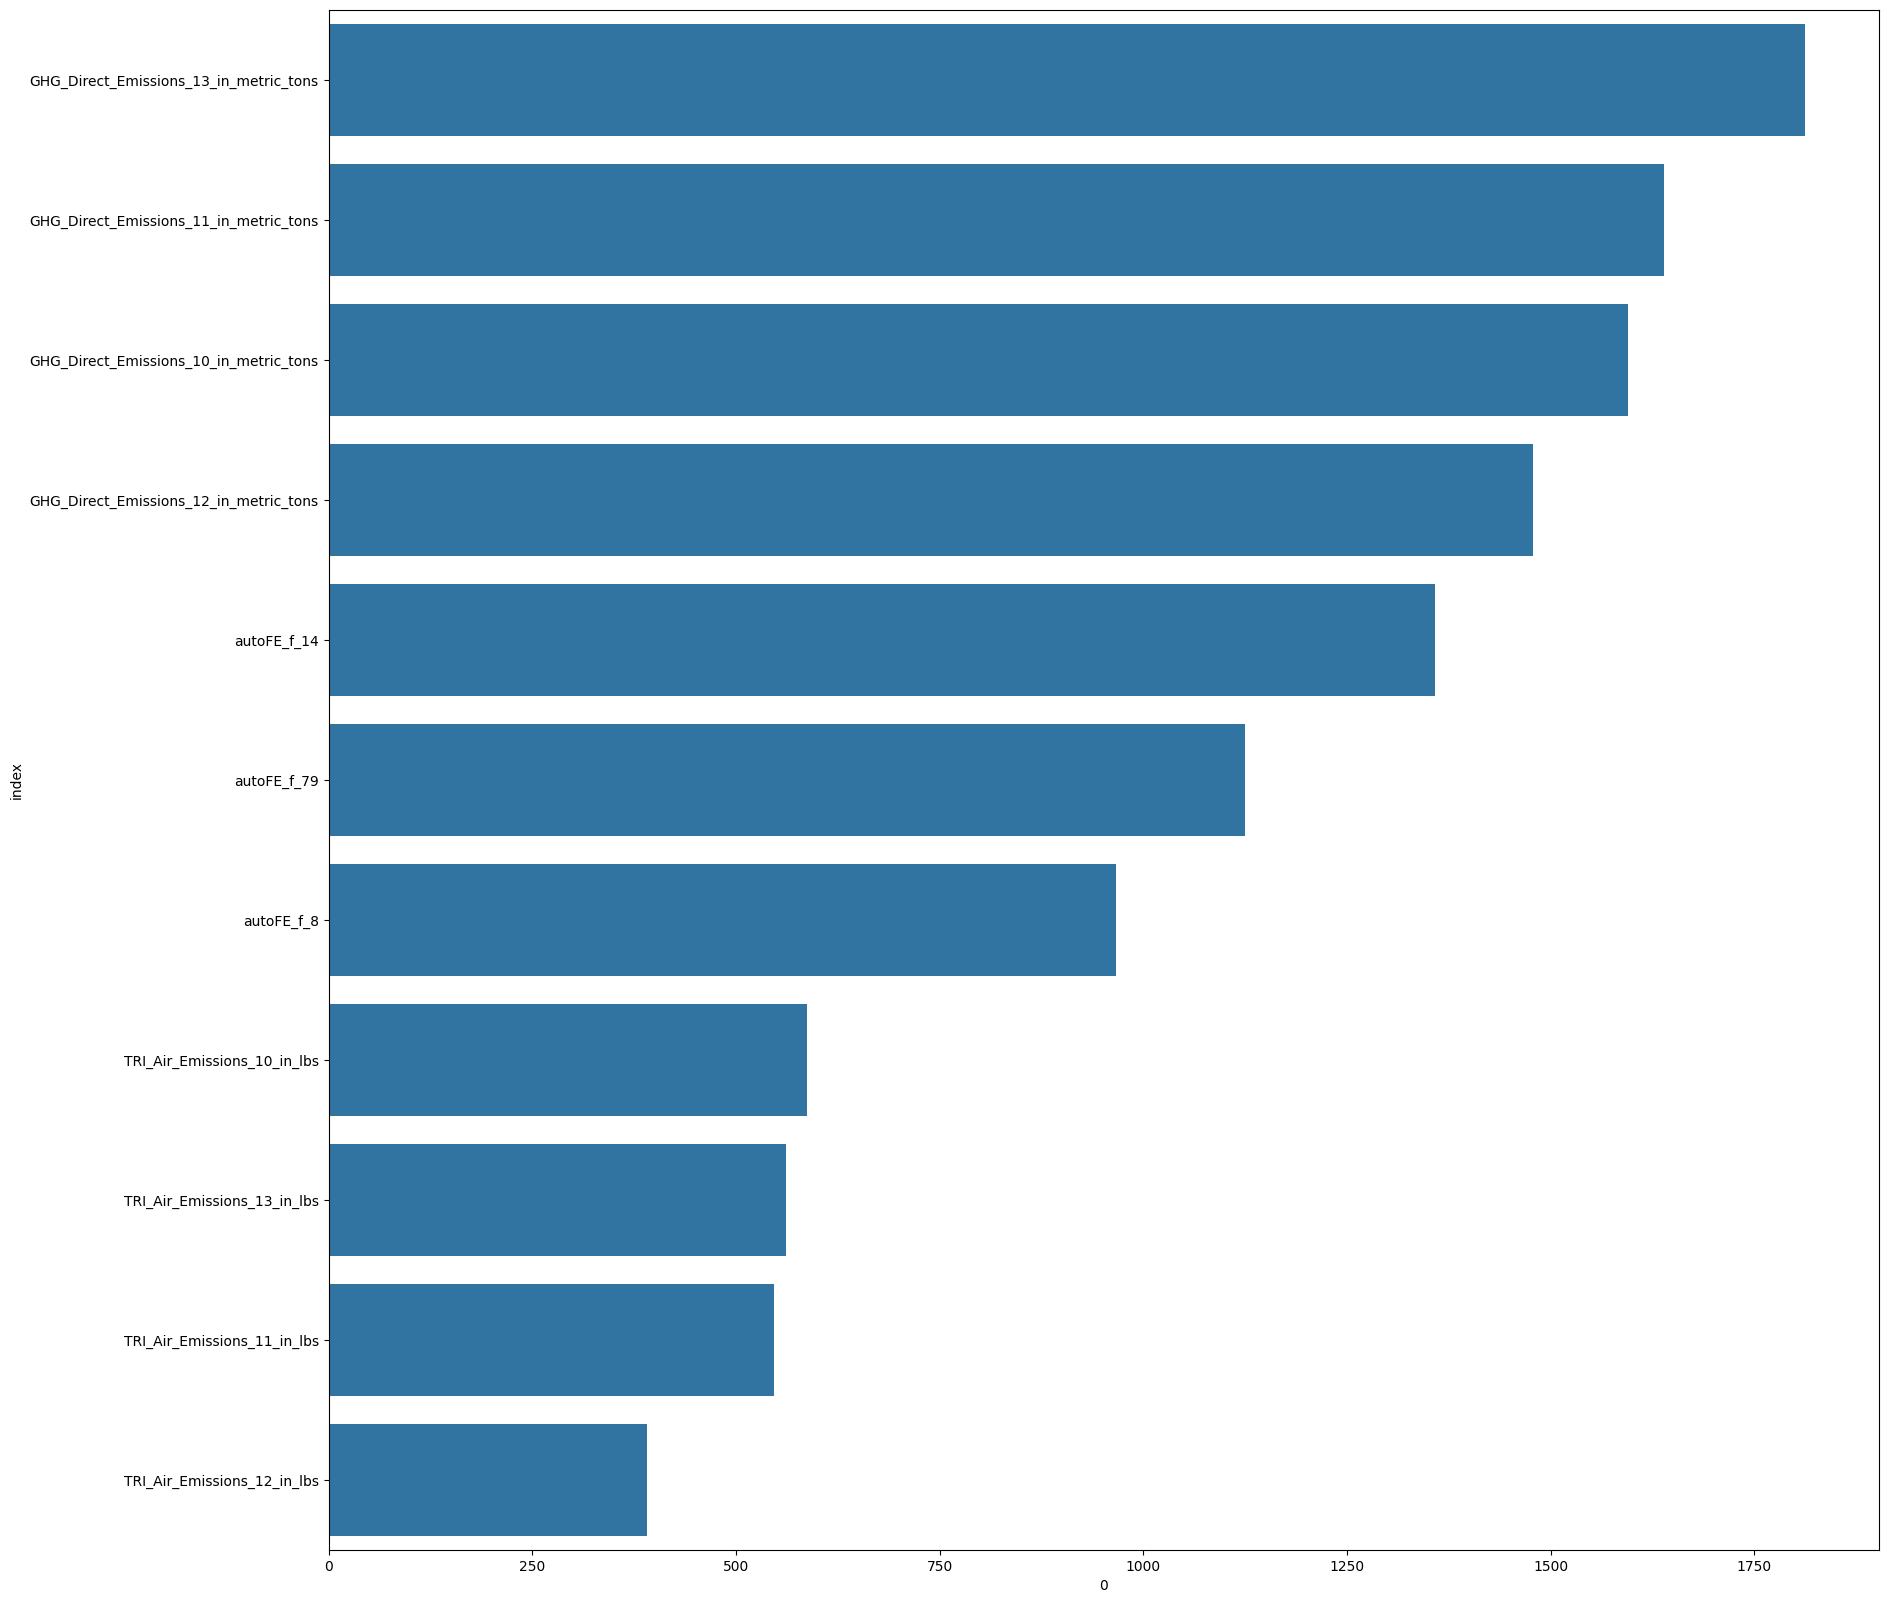

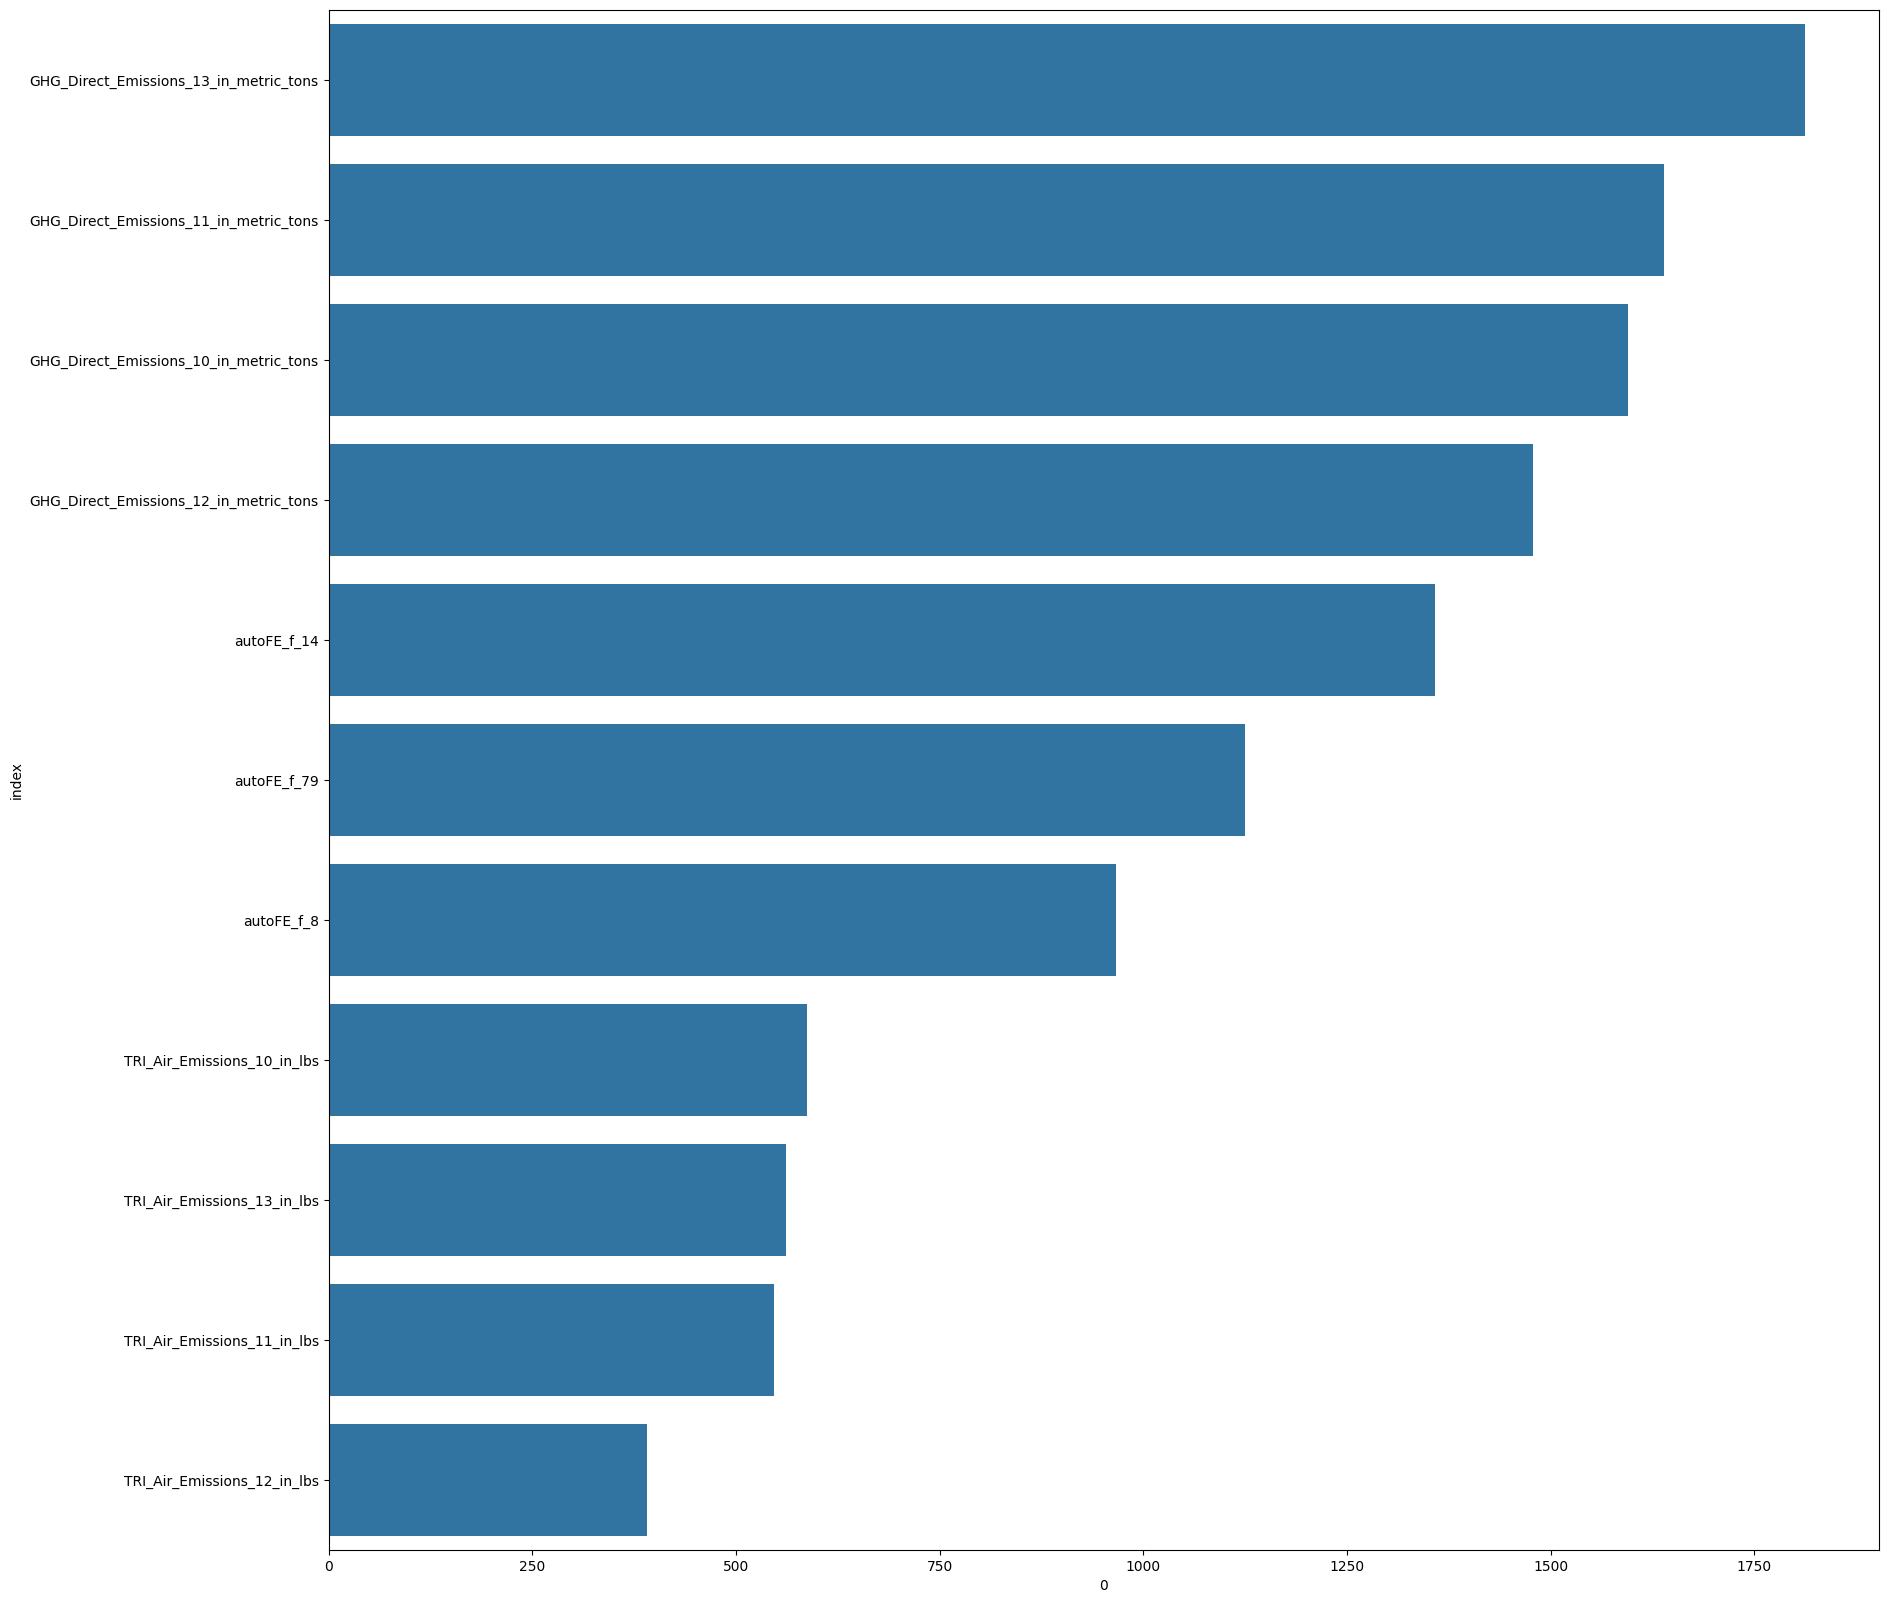

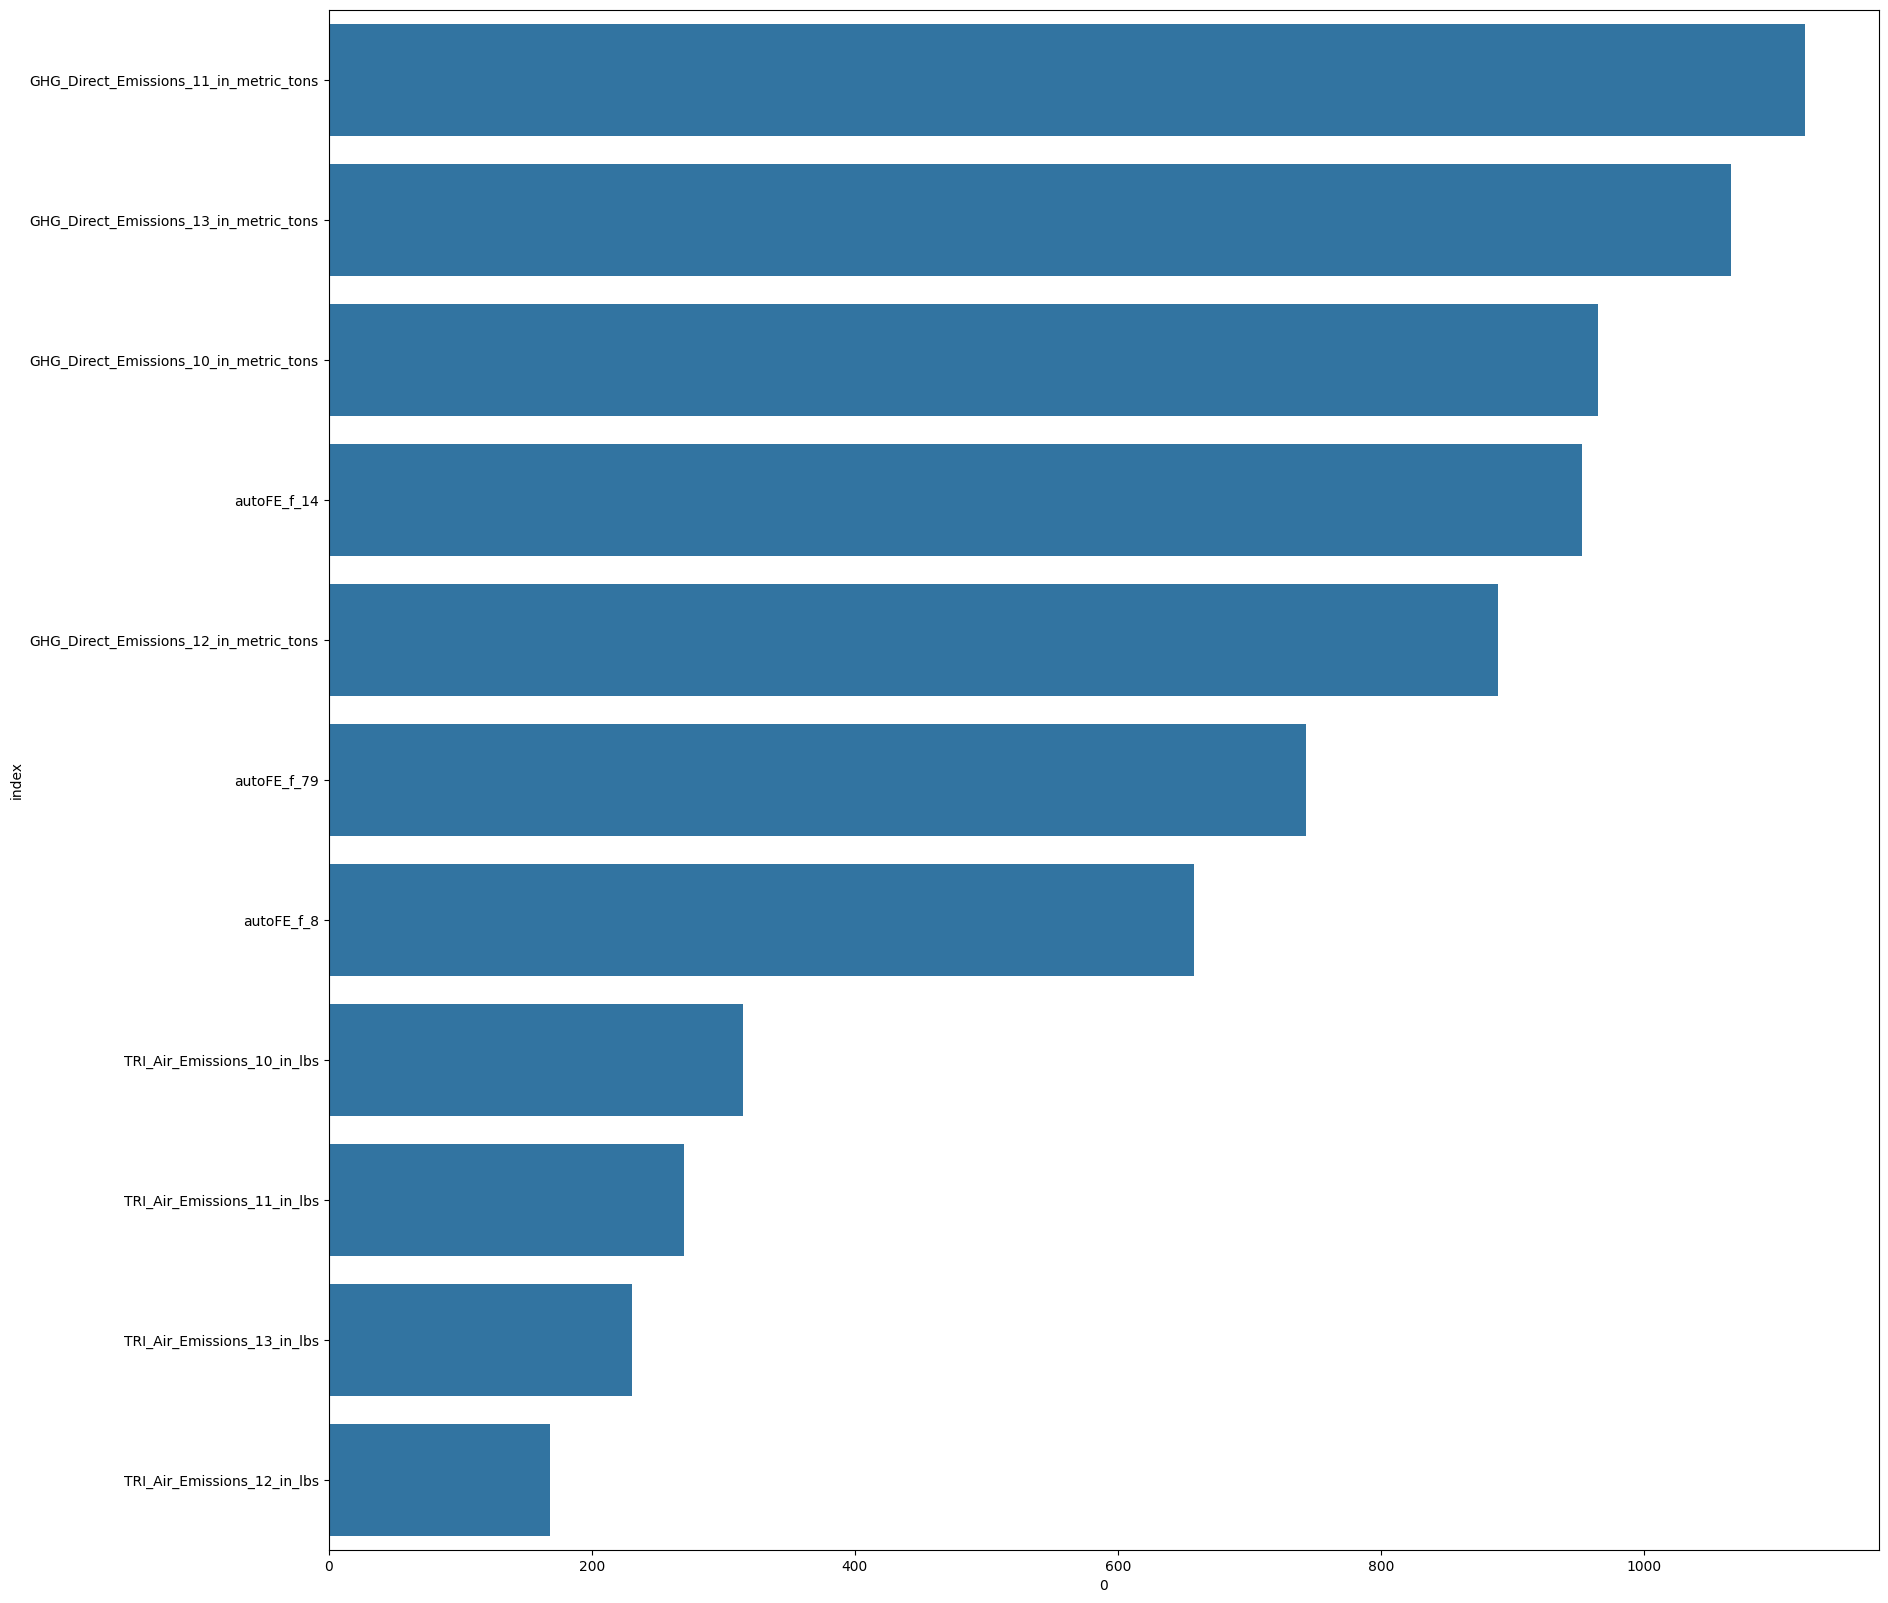

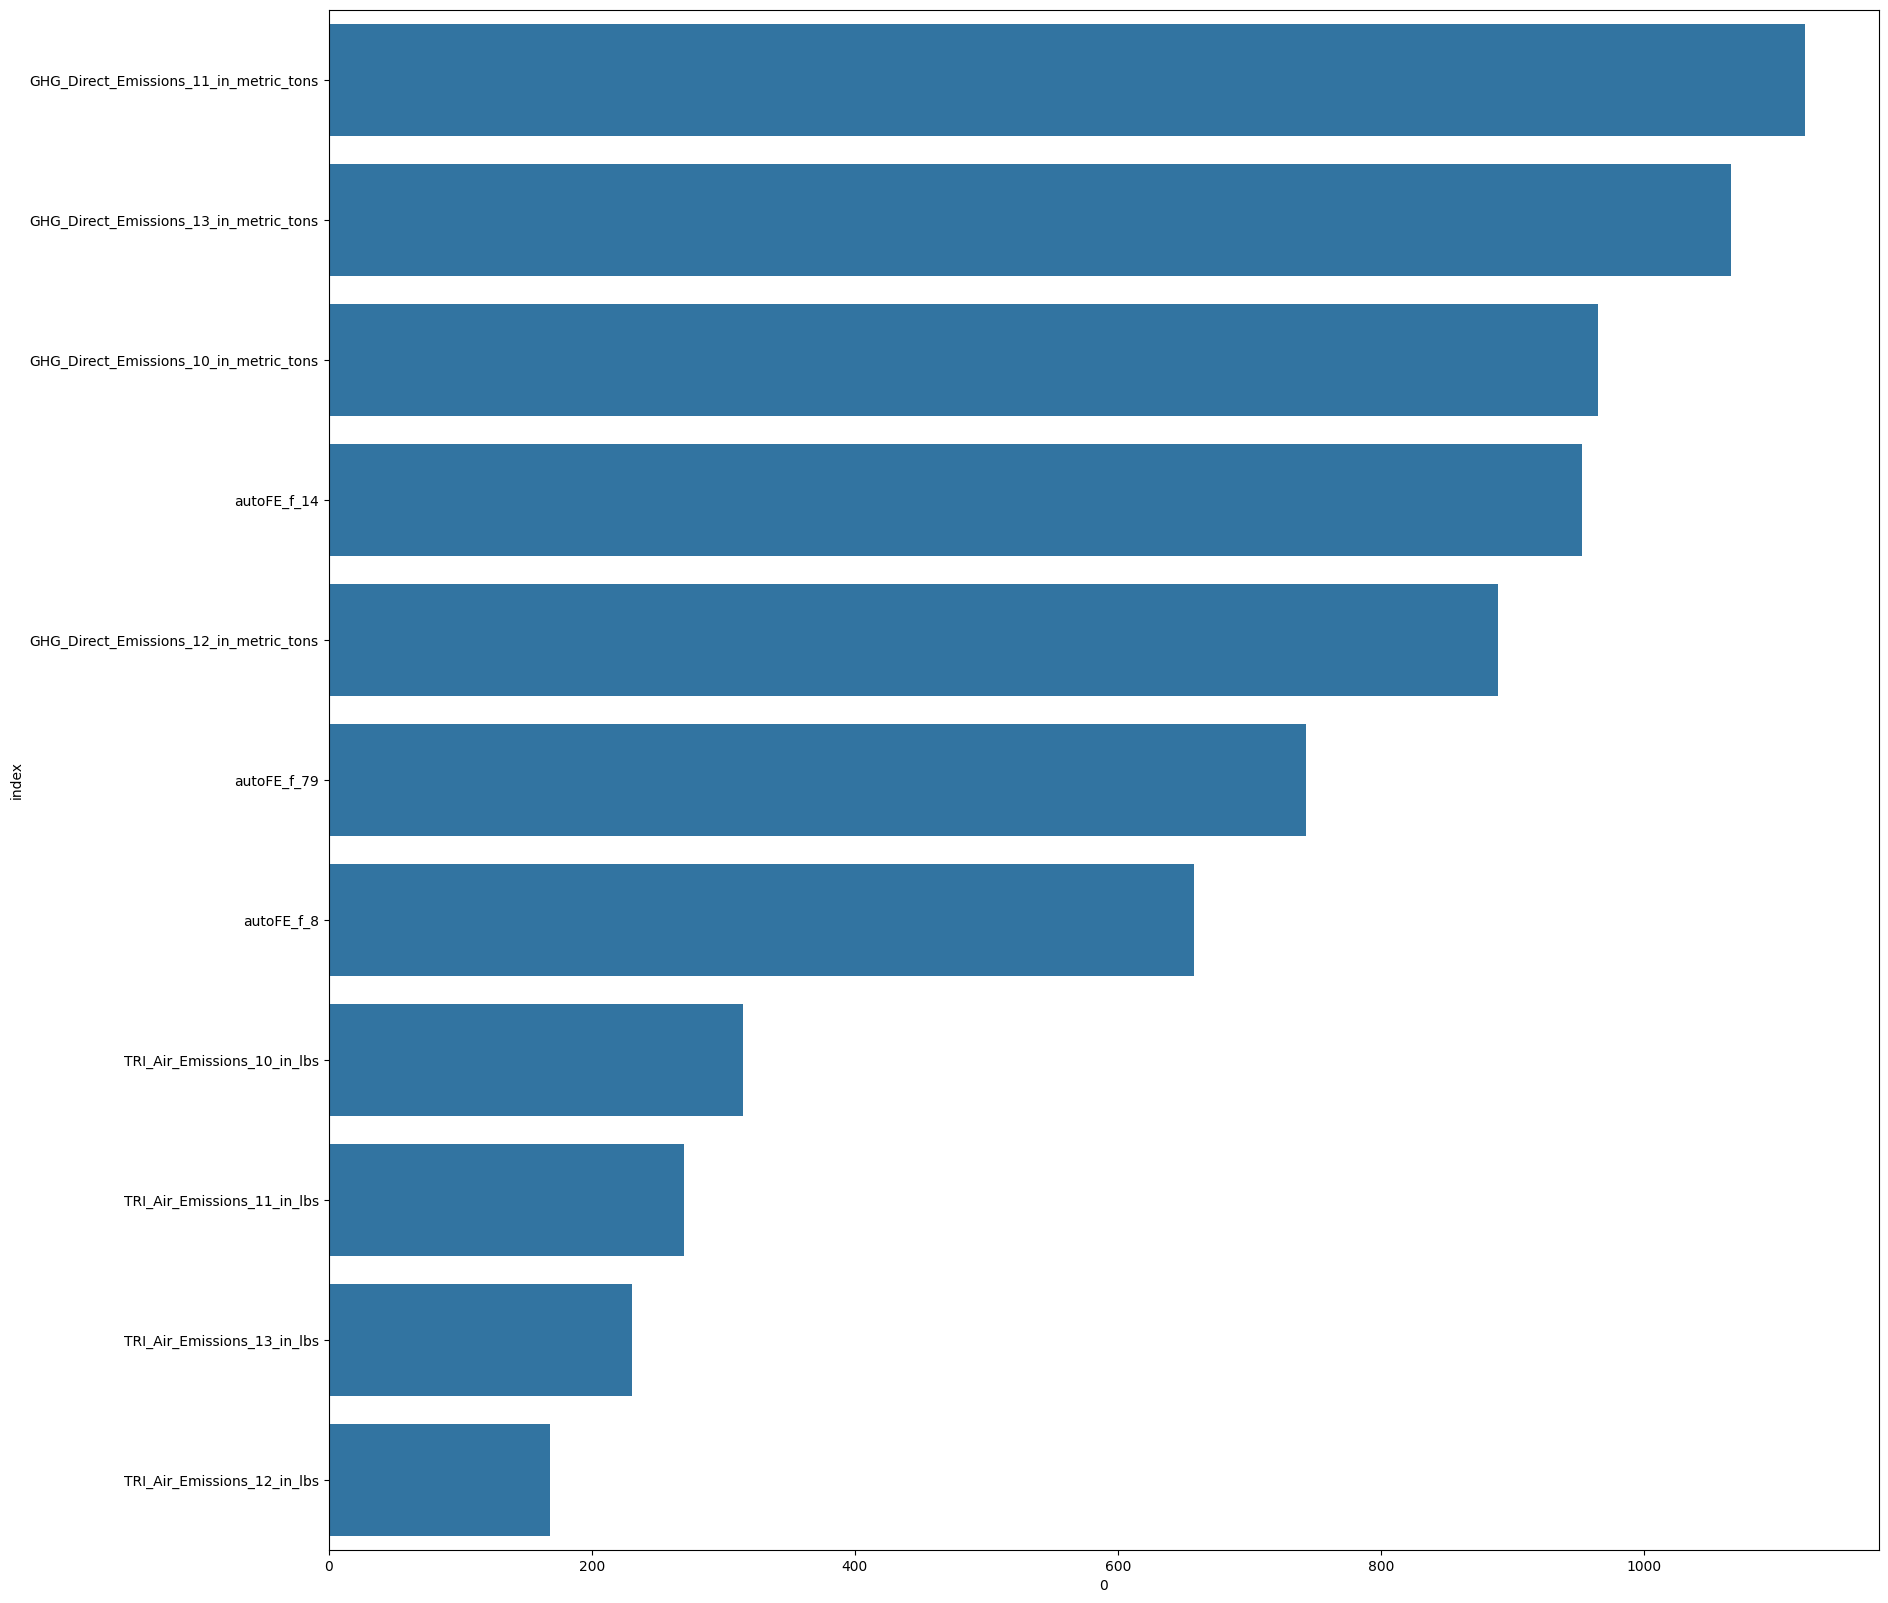

In [ ]:
plot_lgb_per_fold(models,usecol=x_train.columns.tolist())

In [ ]:
usecol = [x for x in x_train.columns if "autoFE" not in x]

In [ ]:
usecol = ['TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
          'autoFE_f_79',
          'autoFE_f_8',
          'autoFE_f_14']

In [ ]:
x_train[usecol]

,TRI_Air_Emissions_10_in_lbs,TRI_Air_Emissions_11_in_lbs,TRI_Air_Emissions_12_in_lbs,TRI_Air_Emissions_13_in_lbs,GHG_Direct_Emissions_10_in_metric_tons,GHG_Direct_Emissions_11_in_metric_tons,GHG_Direct_Emissions_12_in_metric_tons,GHG_Direct_Emissions_13_in_metric_tons,autoFE_f_79,autoFE_f_8,autoFE_f_14
0,31566.709644,26644.986107,23410.379903,31809.857564,64816.958901,36588.744606,3.790794e+04,45598.125851,3.790794e+04,4.559813e+04,2.955532e+09
1,NaN,NaN,NaN,NaN,55507.543666,72387.334115,5.822520e+04,76376.547318,7.238733e+04,7.637655e+04,4.239475e+09
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,54811.222708,69339.923002,6.364734e+04,53799.011225,6.933992e+04,6.364734e+04,2.948790e+09
4,NaN,NaN,NaN,NaN,104771.429060,82533.281481,4.834559e+04,57390.377419,8.253328e+04,5.739038e+04,6.012872e+09
...,...,...,...,...,...,...,...,...,...,...,...
4185,NaN,NaN,NaN,NaN,54978.841280,56463.765036,3.522786e+06,76642.640670,3.522786e+06,3.522786e+06,4.213724e+09
4186,NaN,NaN,NaN,NaN,208375.435367,57066.624445,4.858030e+04,26892.366779,5.706662e+04,4.858030e+04,5.603709e+09
4187,NaN,NaN,NaN,NaN,563756.090695,598881.479485,1.665103e+06,543206.073134,1.665103e+06,1.665103e+06,3.062357e+11
4188,NaN,NaN,NaN,NaN,67451.225733,27397.929966,3.922795e+04,46634.777768,3.922795e+04,4.663478e+04,3.145573e+09
